# GAN for simulation of an IOT device signal

## Introduction

Objectives:
- understand principles of Neural Networks
- understand principles of GANs
- create a simulated sensor signal 

## Artificial Neural Networks

<img src="https://upload.wikimedia.org/wikipedia/commons/1/10/Blausen_0657_MultipolarNeuron.png">

Artificial neural networks (ANNs) or connectionist systems are computing systems vaguely inspired by the biological neural networks. Such systems "learn" to perform tasks by considering examples, generally without being programmed with any task-specific rules. For example, in image recognition, they might learn to identify images that contain cats by analyzing example images that have been manually labeled as "cat" or "no cat" and using the results to identify cats in other images. They do this without any prior knowledge about cats, e.g., that they have fur, tails, whiskers and cat-like faces. Instead, they automatically generate identifying characteristics from the learning material that they process.

An ANN is based on a collection of connected units or nodes called artificial neurons which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it.

In common ANN implementations, the signal at a connection between artificial neurons is a real number, and the output of each artificial neuron is computed by some non-linear function of the sum of its inputs. The connections between artificial neurons are called 'edges'. Artificial neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Artificial neurons may have a threshold such that the signal is only sent if the aggregate signal crosses that threshold. Typically, artificial neurons are aggregated into layers. Different layers may perform different kinds of transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.

https://en.wikipedia.org/wiki/Artificial_neural_network

<img src="https://cdn-images-1.medium.com/max/479/1*QVIyc5HnGDWTNX3m-nIm9w.png">   



## Generative Adversarial Networks (GANs)
This is a neural network architecture that features two AIs competing against each other with one AI trying to generate fake data, and the other to identify fake data.For example, imagine an algorithm designed to generate fake videos of well-known individuals, such as celebrities or politicians pairing off against a counter algorithm designed to identify those fake videos.

GANs were introduced in a paper by Ian Goodfellow and other researchers at the University of Montreal.
https://arxiv.org/abs/1406.2661  


<img src="https://deeplearning4j.org/img/gan_schema.png">

One neural network, called the generator, generates new data instances, while the other, the discriminator, evaluates them for authenticity; i.e. the discriminator decides whether each instance of data it reviews belongs to the actual training dataset or not.

Let’s say we’re trying to do something more banal than mimic the Mona Lisa. We’re going to generate hand-written numerals like those found in the MNIST dataset, which is taken from the real world. The goal of the discriminator, when shown an instance from the true MNIST dataset, is to recognize them as authentic.

Meanwhile, the generator is creating new images that it passes to the discriminator. It does so in the hopes that they, too, will be deemed authentic, even though they are fake. The goal of the generator is to generate passable hand-written digits, to lie without being caught. The goal of the discriminator is to identify images coming from the generator as fake.

Here are the steps a GAN takes:

- The generator takes in random numbers and returns an image.
- This generated image is fed into the discriminator alongside a stream of images taken from the actual dataset.
- The discriminator takes in both real and fake images and returns probabilities, a number between 0 and 1, with 1 representing a prediction of authenticity and 0 representing fake.

So you have a double feedback loop:

- The discriminator is in a feedback loop with the ground truth of the images, which we know.
- The generator is in a feedback loop with the discriminator.

<img src="https://deeplearning4j.org/img/GANs.png">  




Material used:  
https://blog.paperspace.com/implementing-gans-in-tensorflow/  
https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8
https://deeplearning4j.org/generative-adversarial-network

Useful links:  
https://www.tensorflow.org/  
https://pytorch.org/  
https://deeplearning4j.org/index.html  
http://www.aplus.ai/download/deeplearning-guide.pdf  


## Create a simulated sensor signal

In [1]:
# Mathematics and Tensor
import numpy as np
import math
import random
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

### Generating Training Data

In [2]:
# Create a signal to learn
def get_y(x):
    return math.sin(x)

def sample_data(n=10000, scale=14):
    data = []

    x = scale*(np.random.random_sample((n,)))
    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

# Create random data noise for generator input
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

### Visualizing example batch of generated data

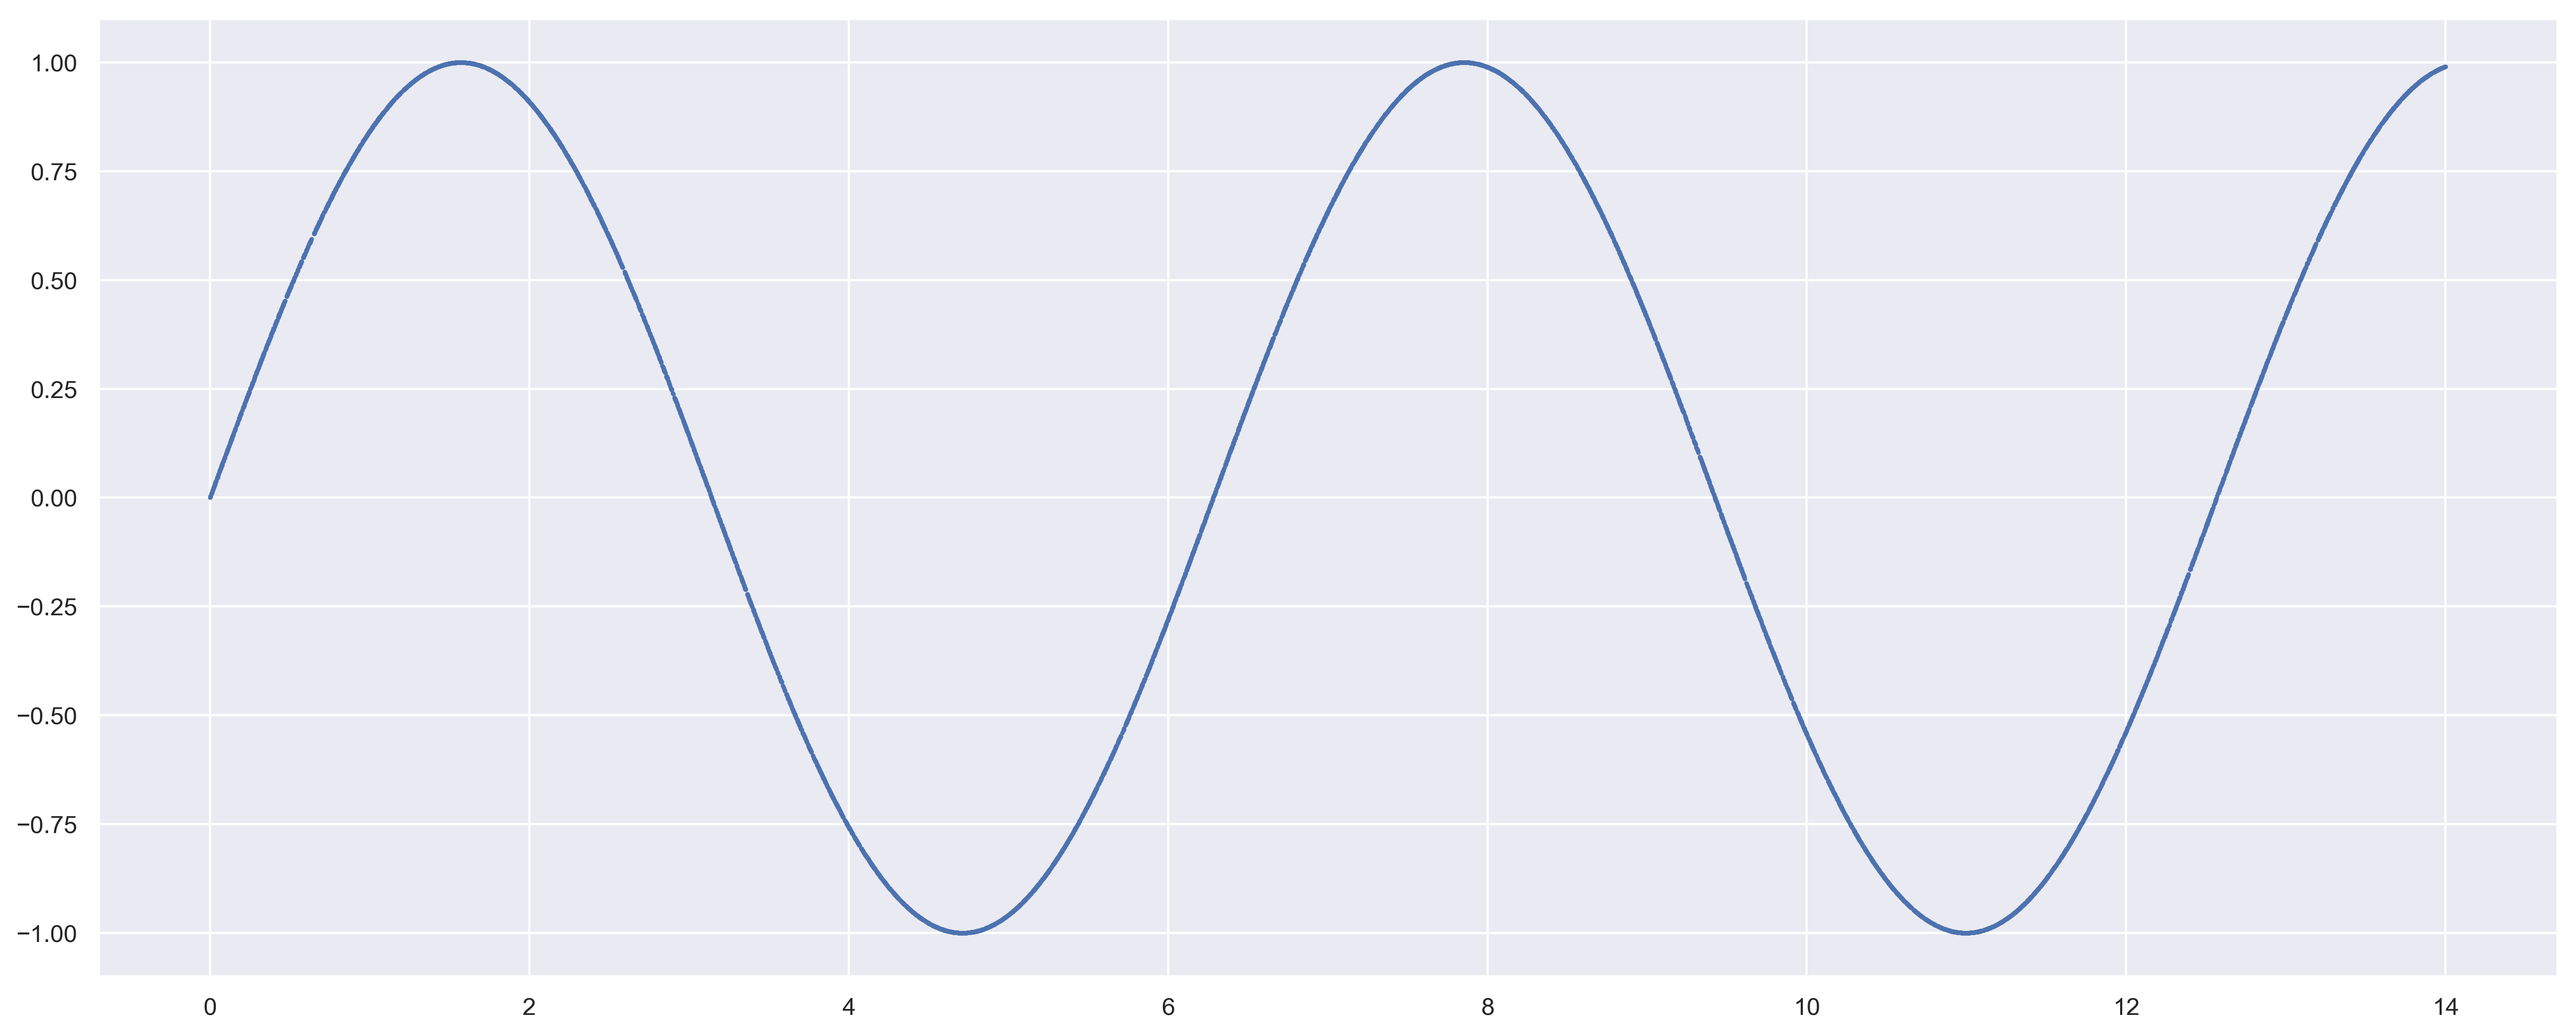

In [3]:
example_data = sample_data()

# plot example data
plt.figure(figsize=(20,8), dpi=300)
plt.scatter(example_data[:,0], example_data[:,1], s=1)

plt.show()

In [4]:
def generator(Z,hsize=[16, 16],reuse=False): 
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

In [5]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

In [6]:
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

Iterations: 0	 Discriminator loss: 1.0877	 Generator loss: 0.6855


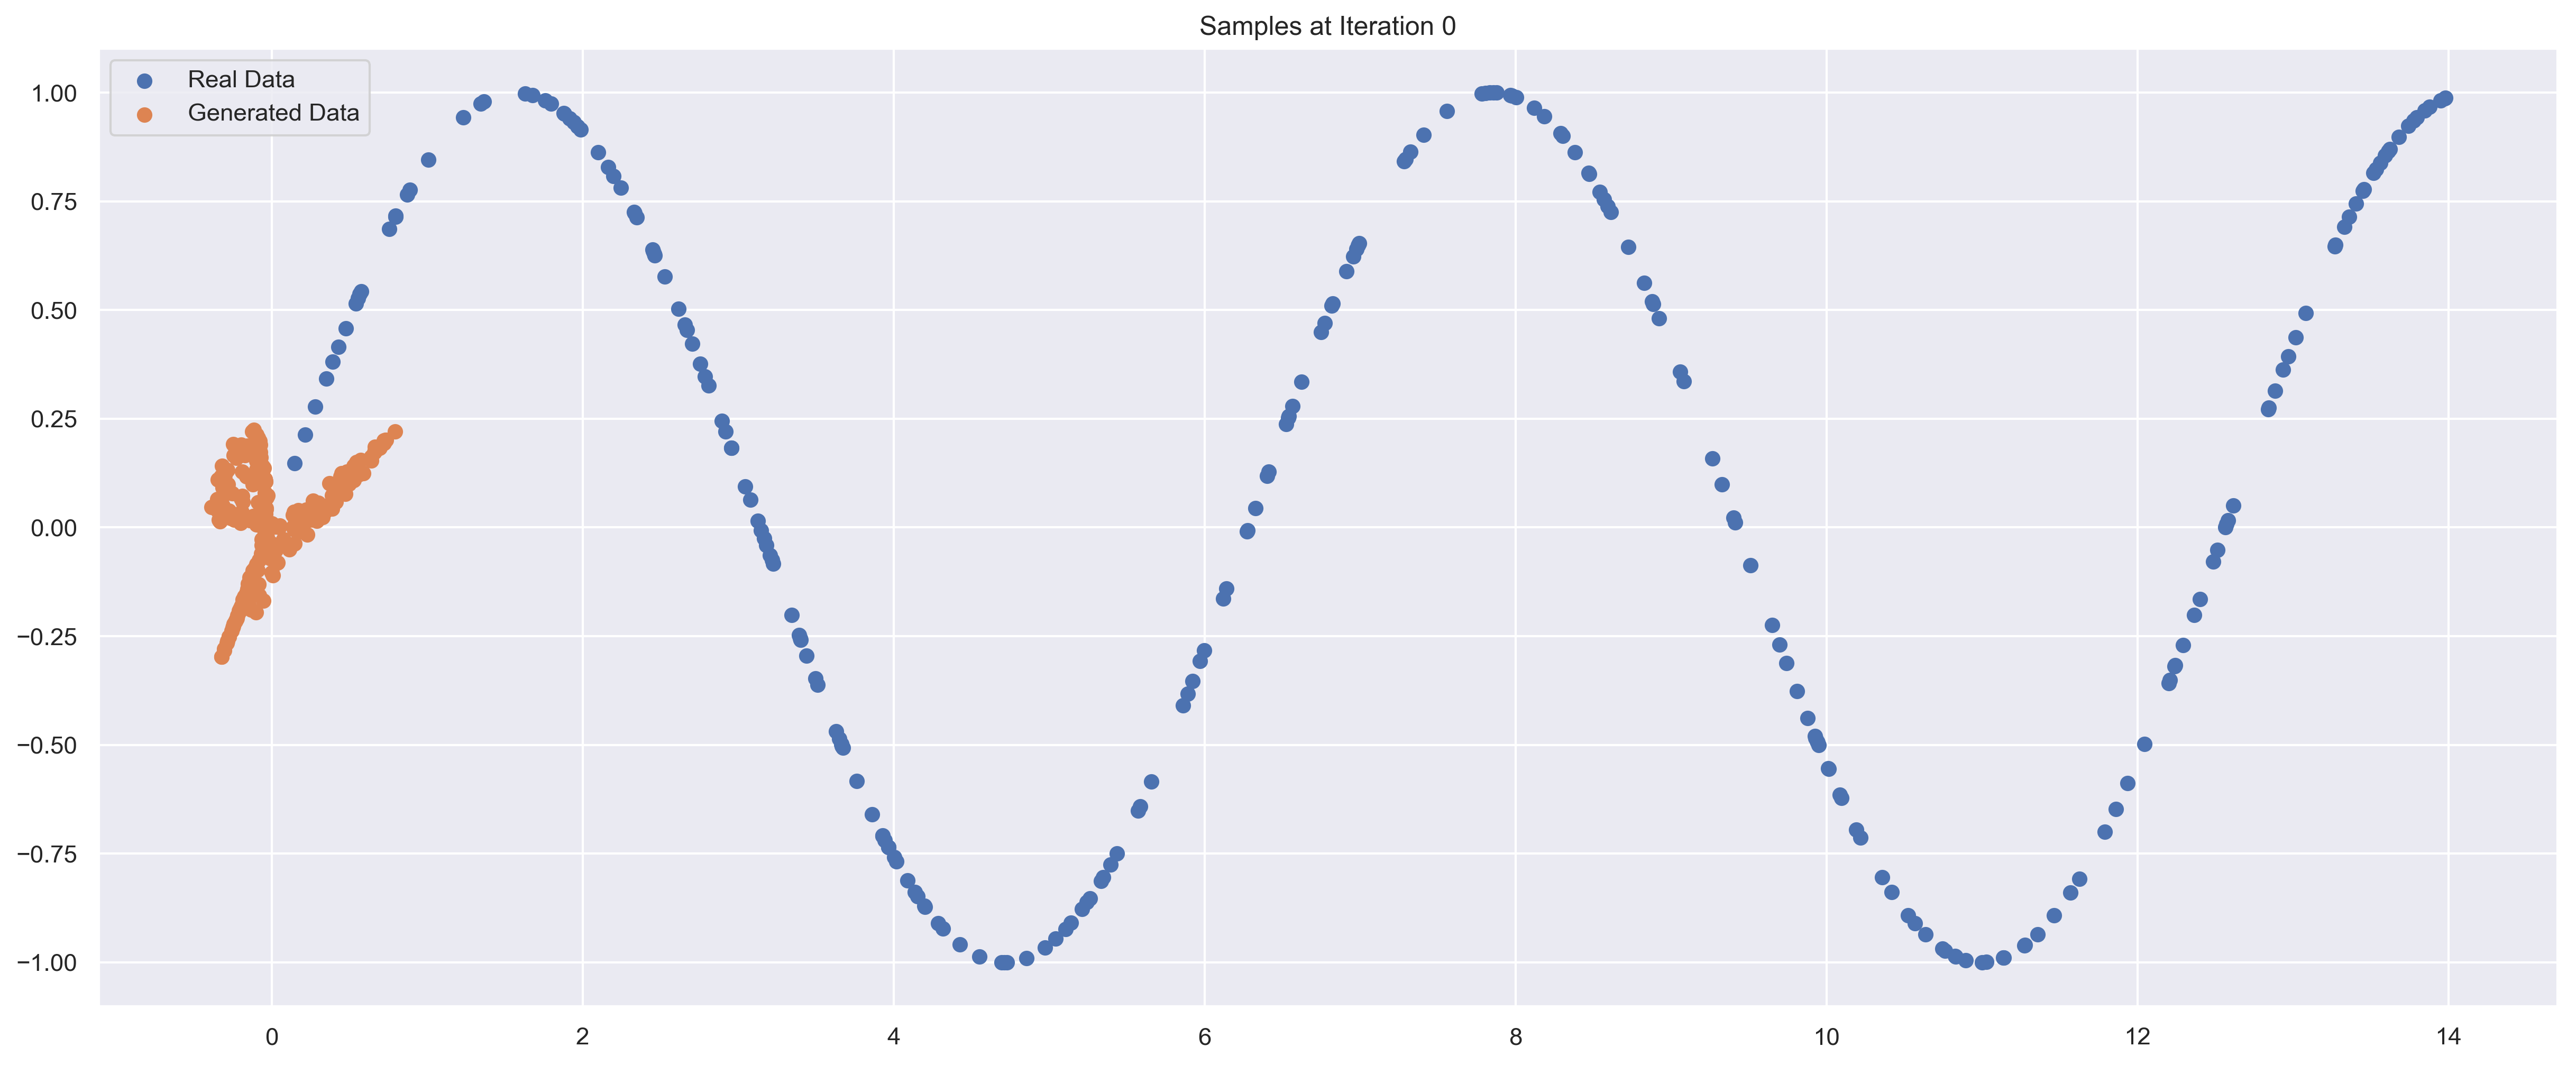

Iterations: 500	 Discriminator loss: 1.3675	 Generator loss: 0.5571


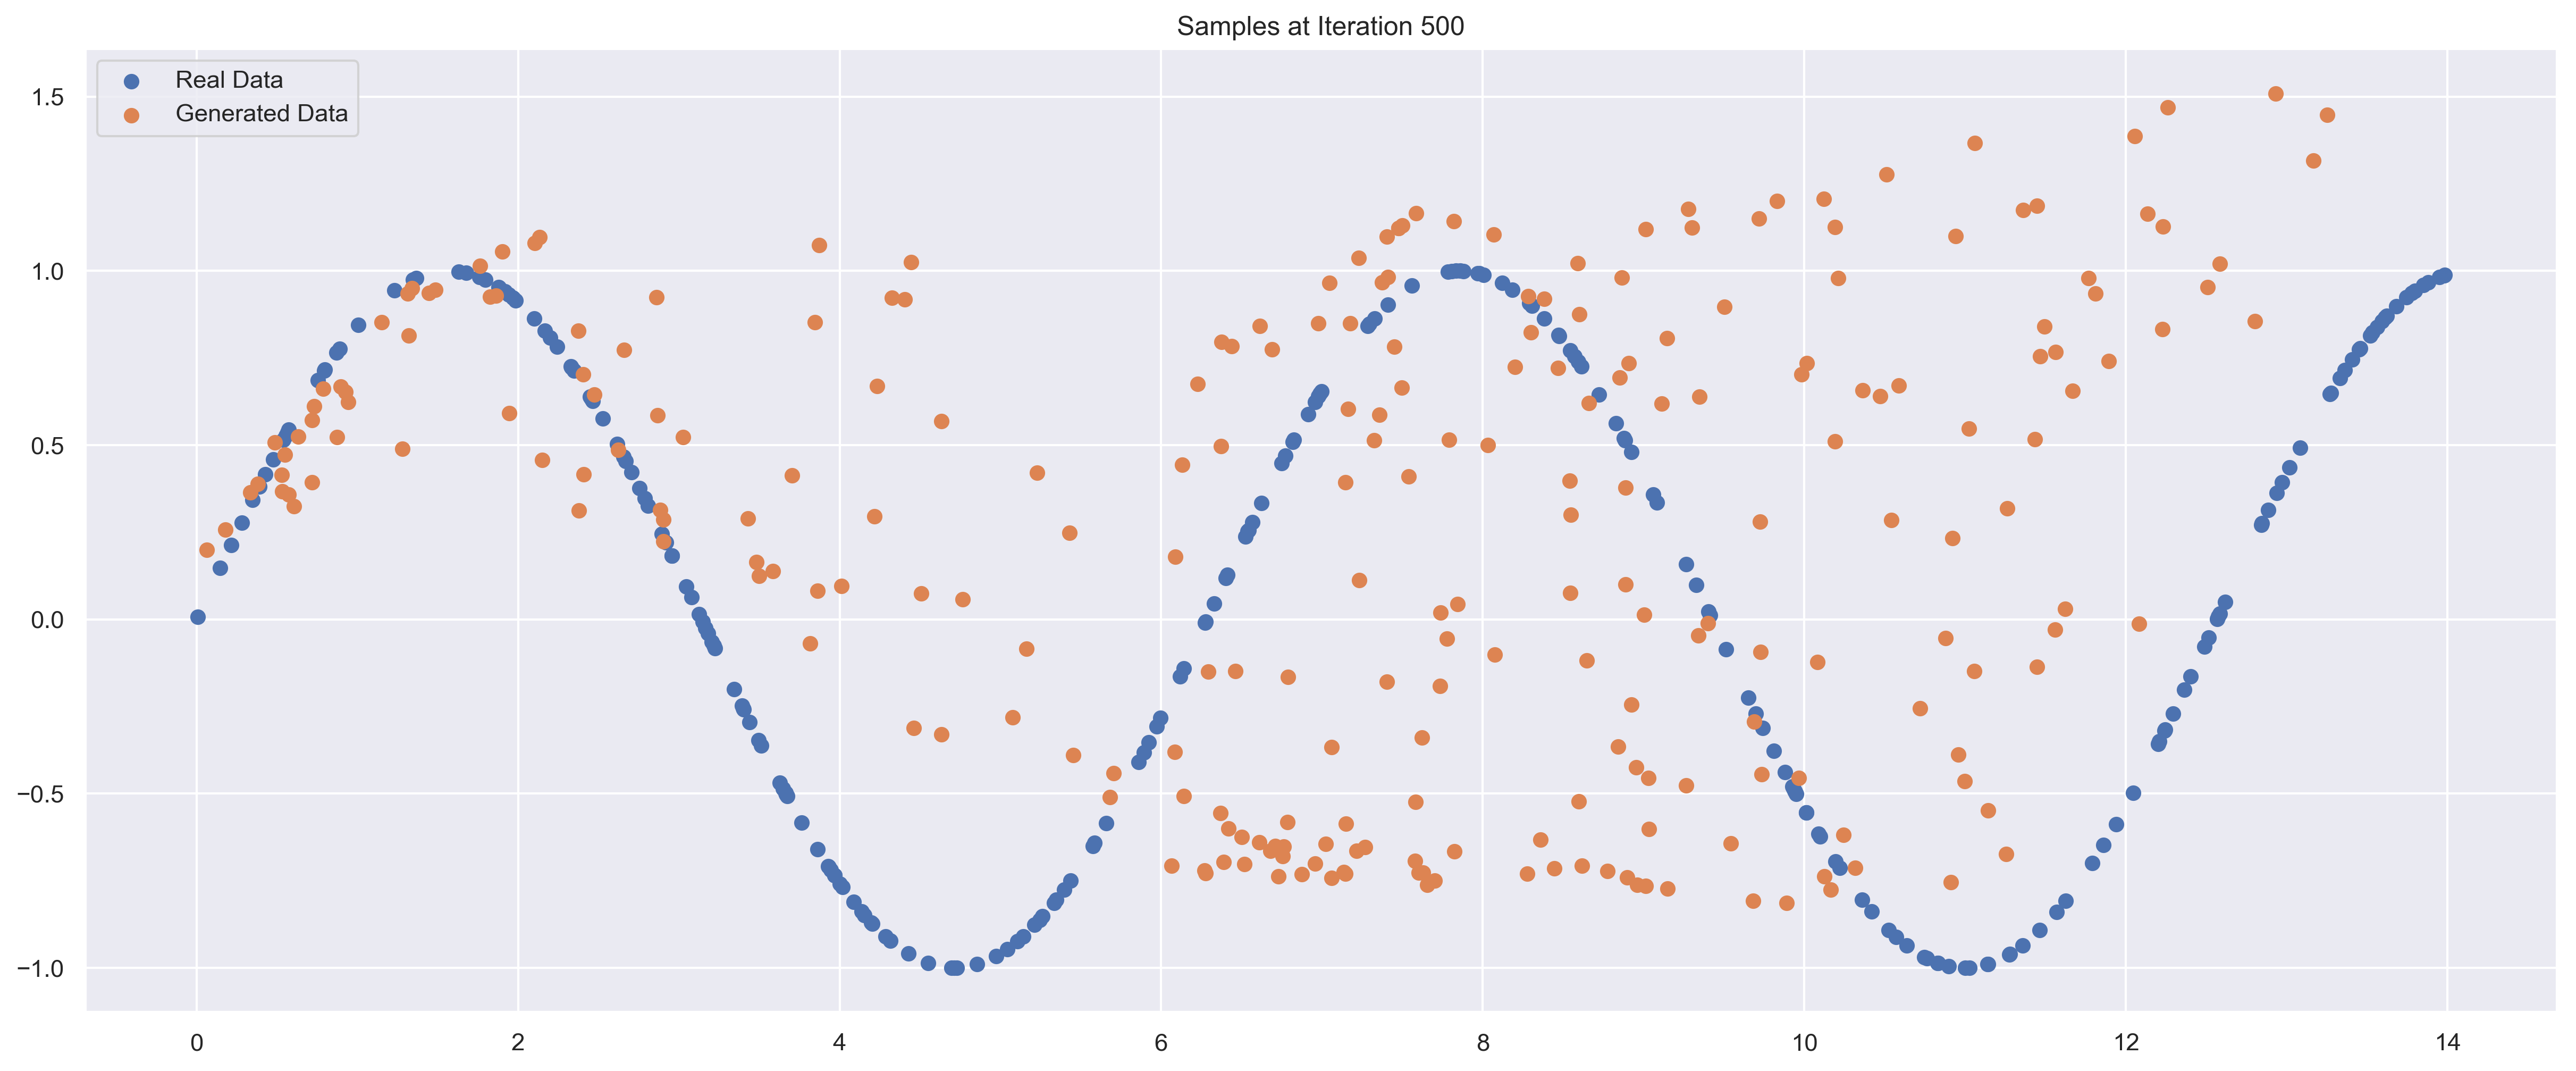

Iterations: 1000	 Discriminator loss: 1.3432	 Generator loss: 0.5259


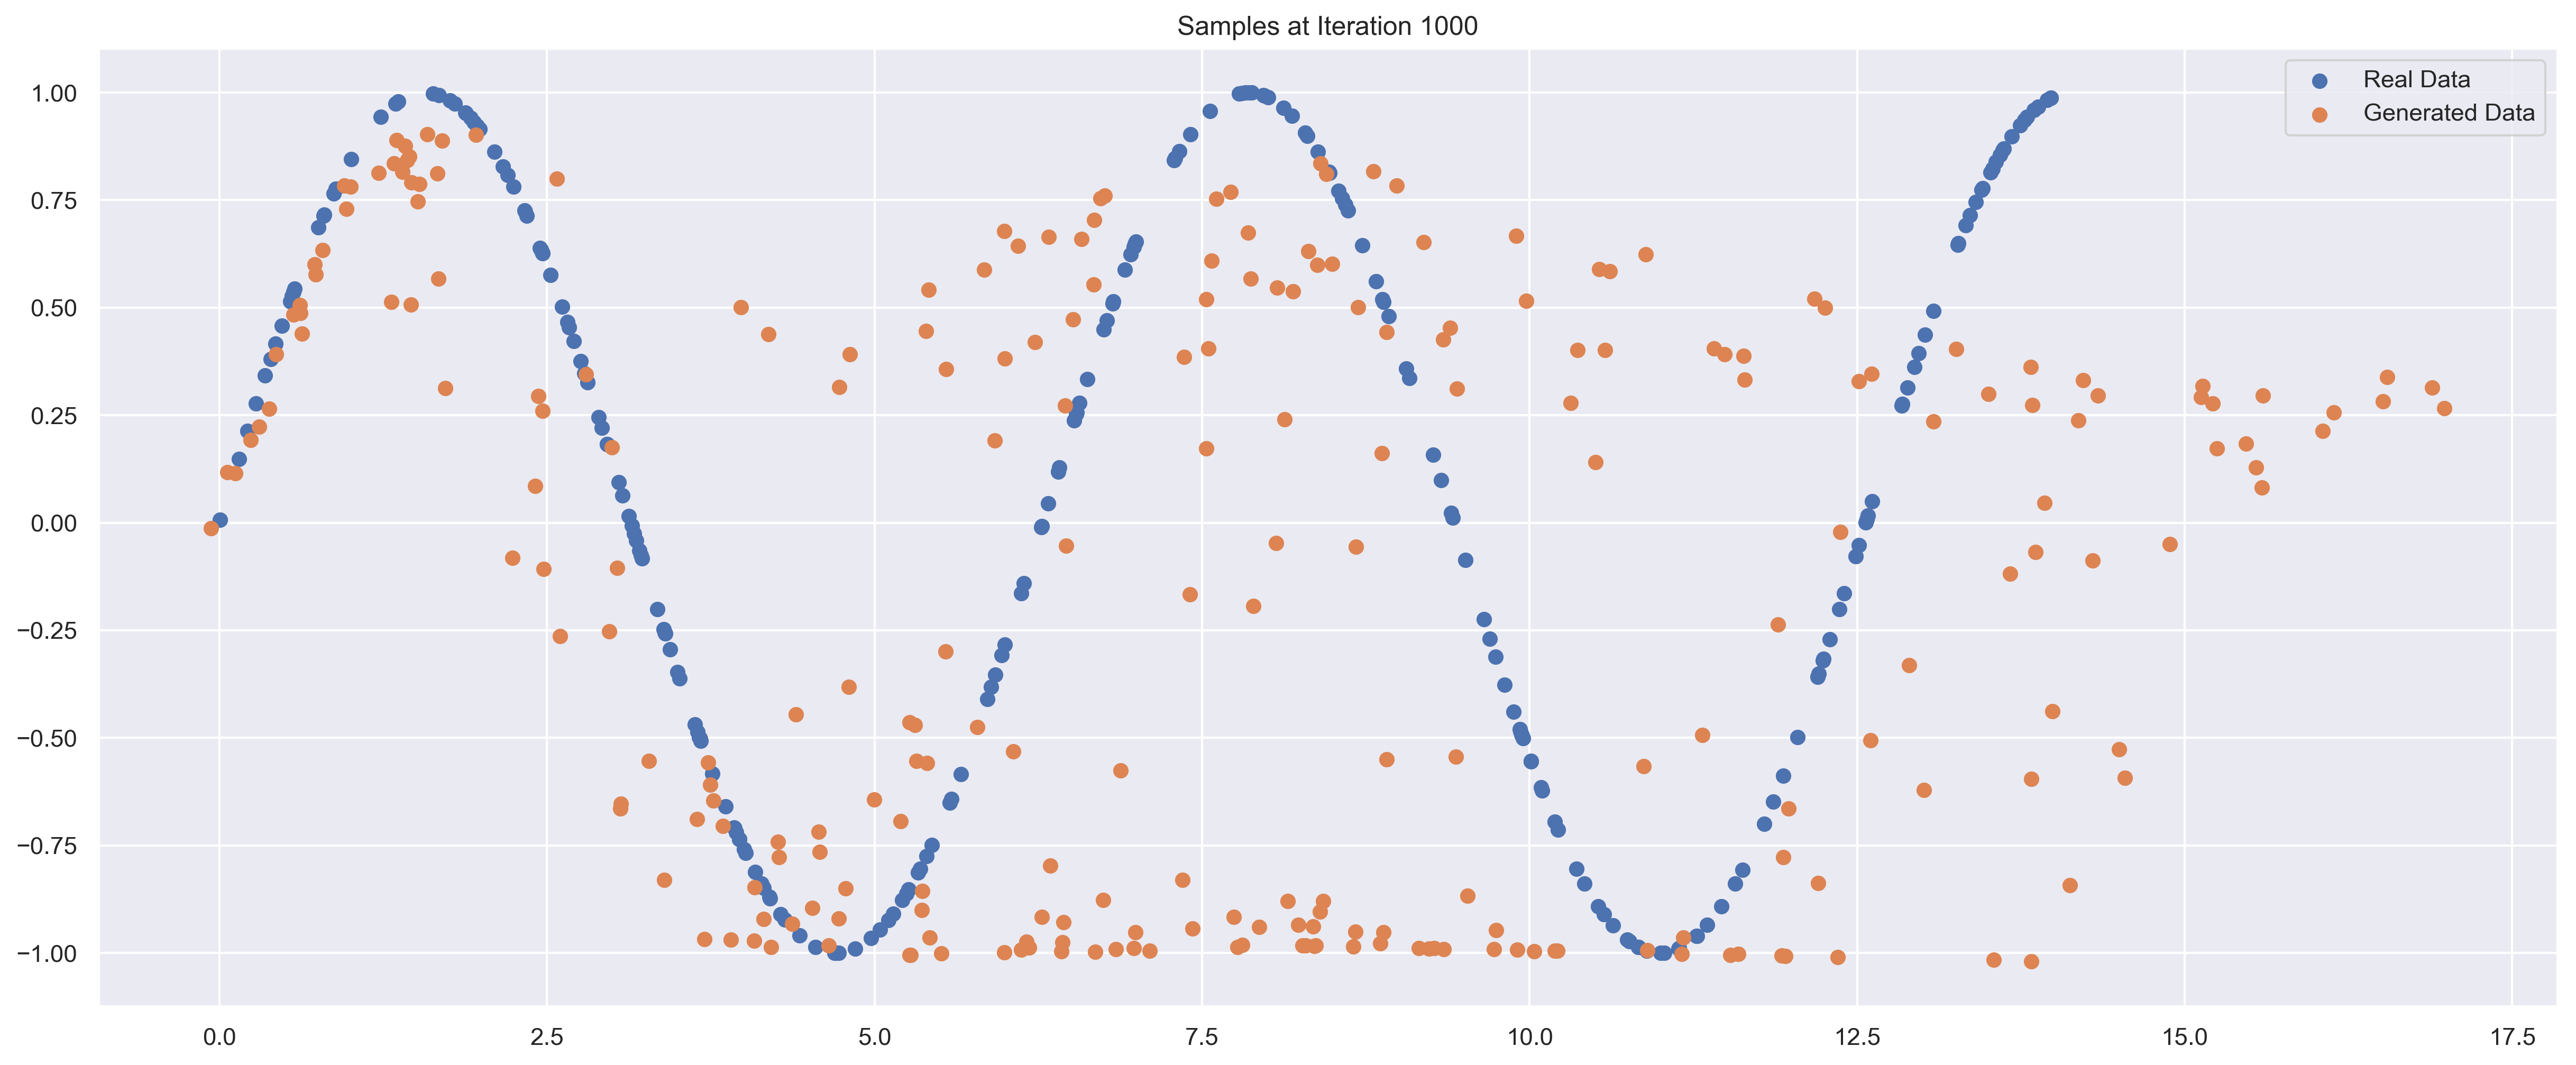

Iterations: 1500	 Discriminator loss: 1.3744	 Generator loss: 0.6072


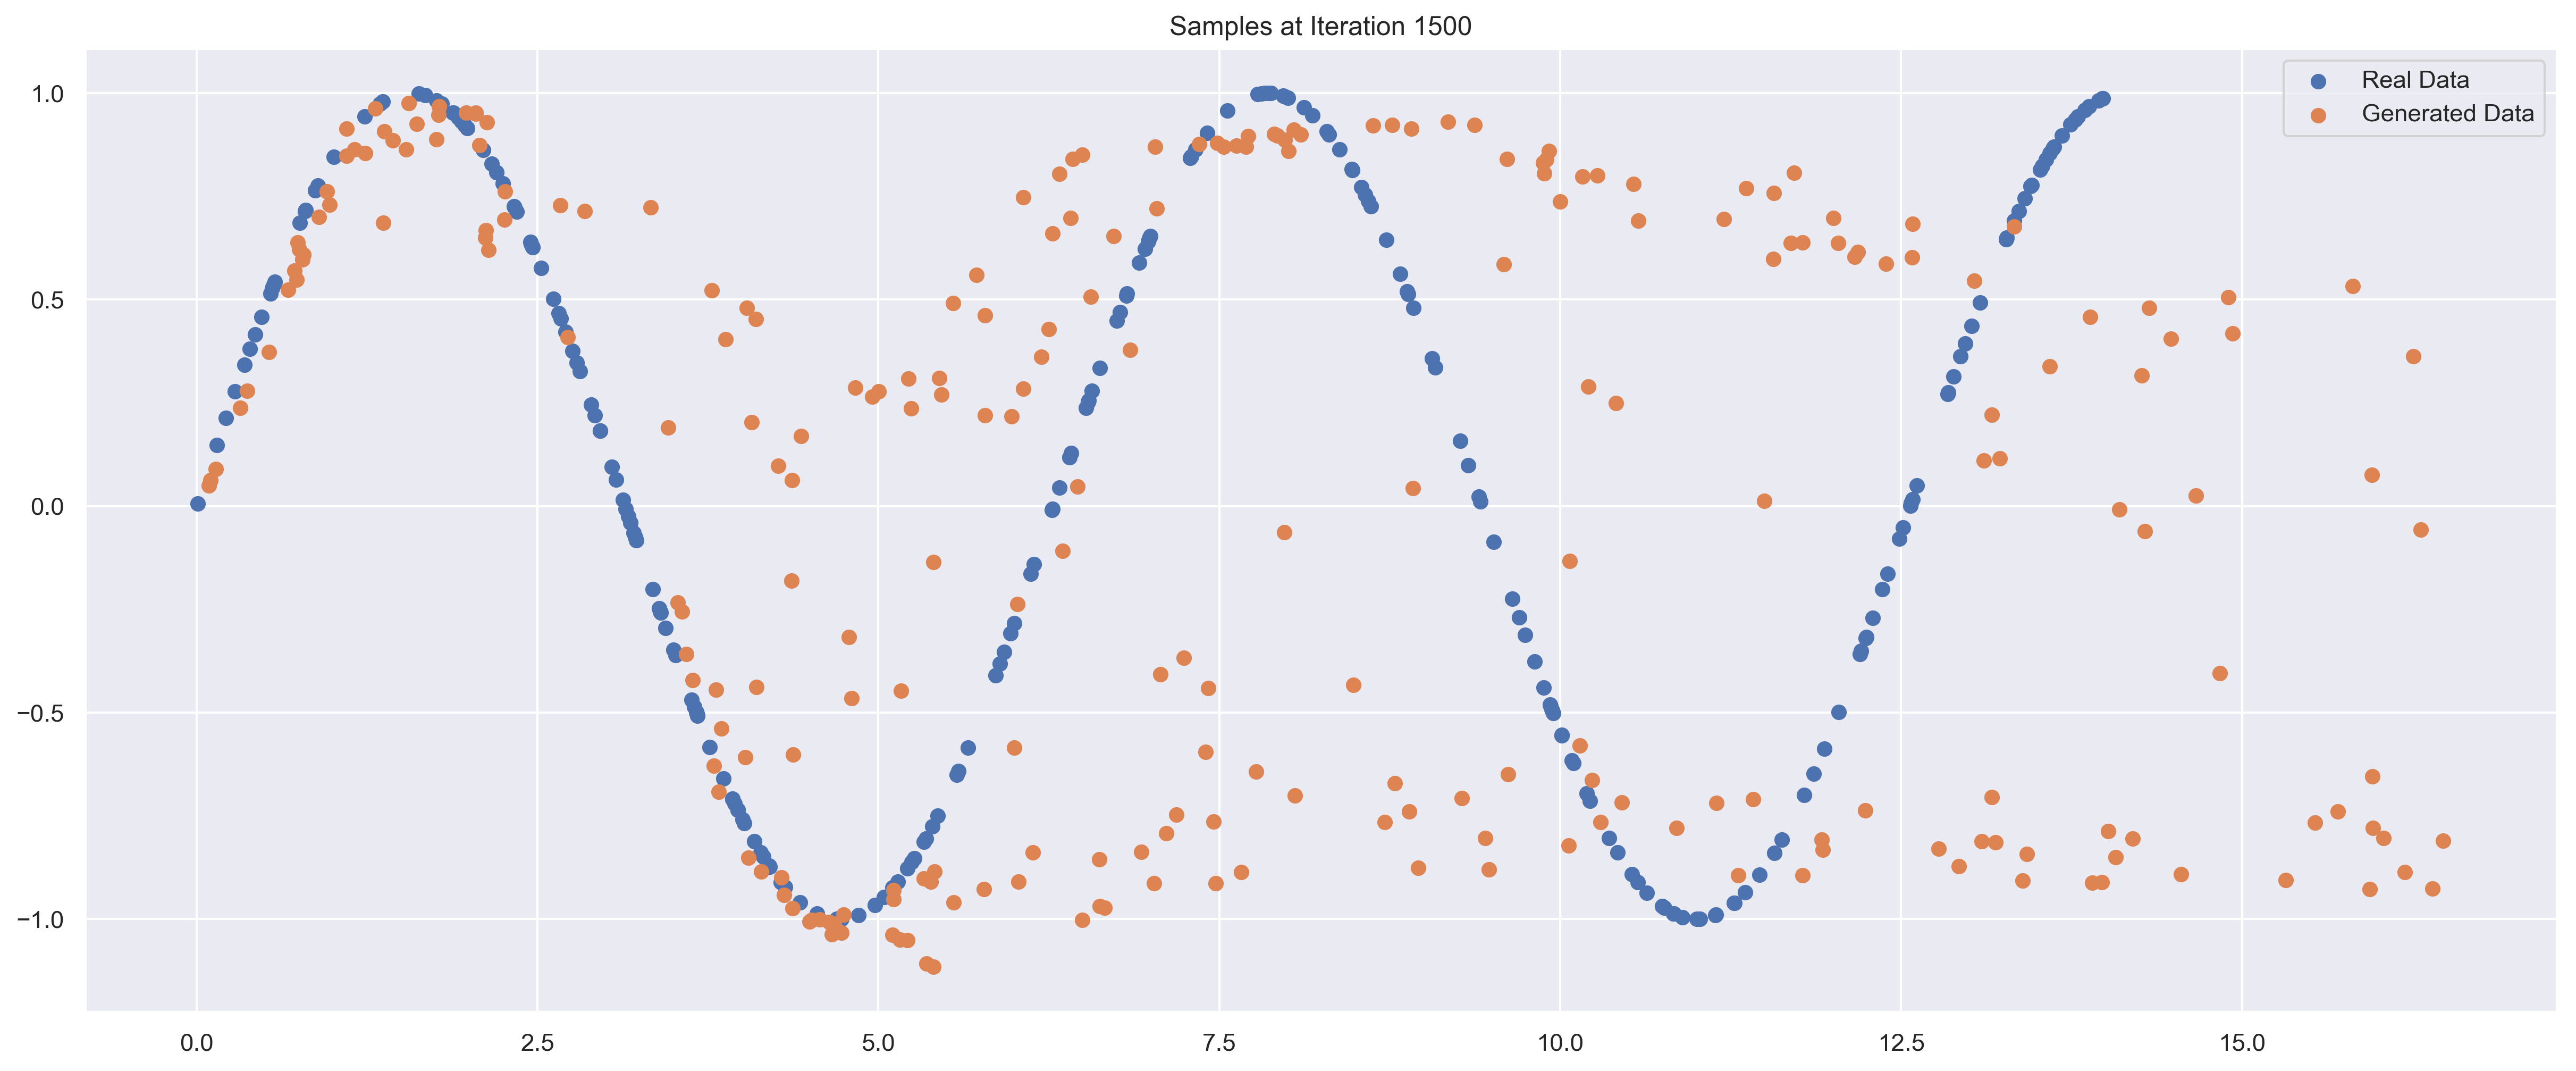

Iterations: 2000	 Discriminator loss: 1.3651	 Generator loss: 0.6059


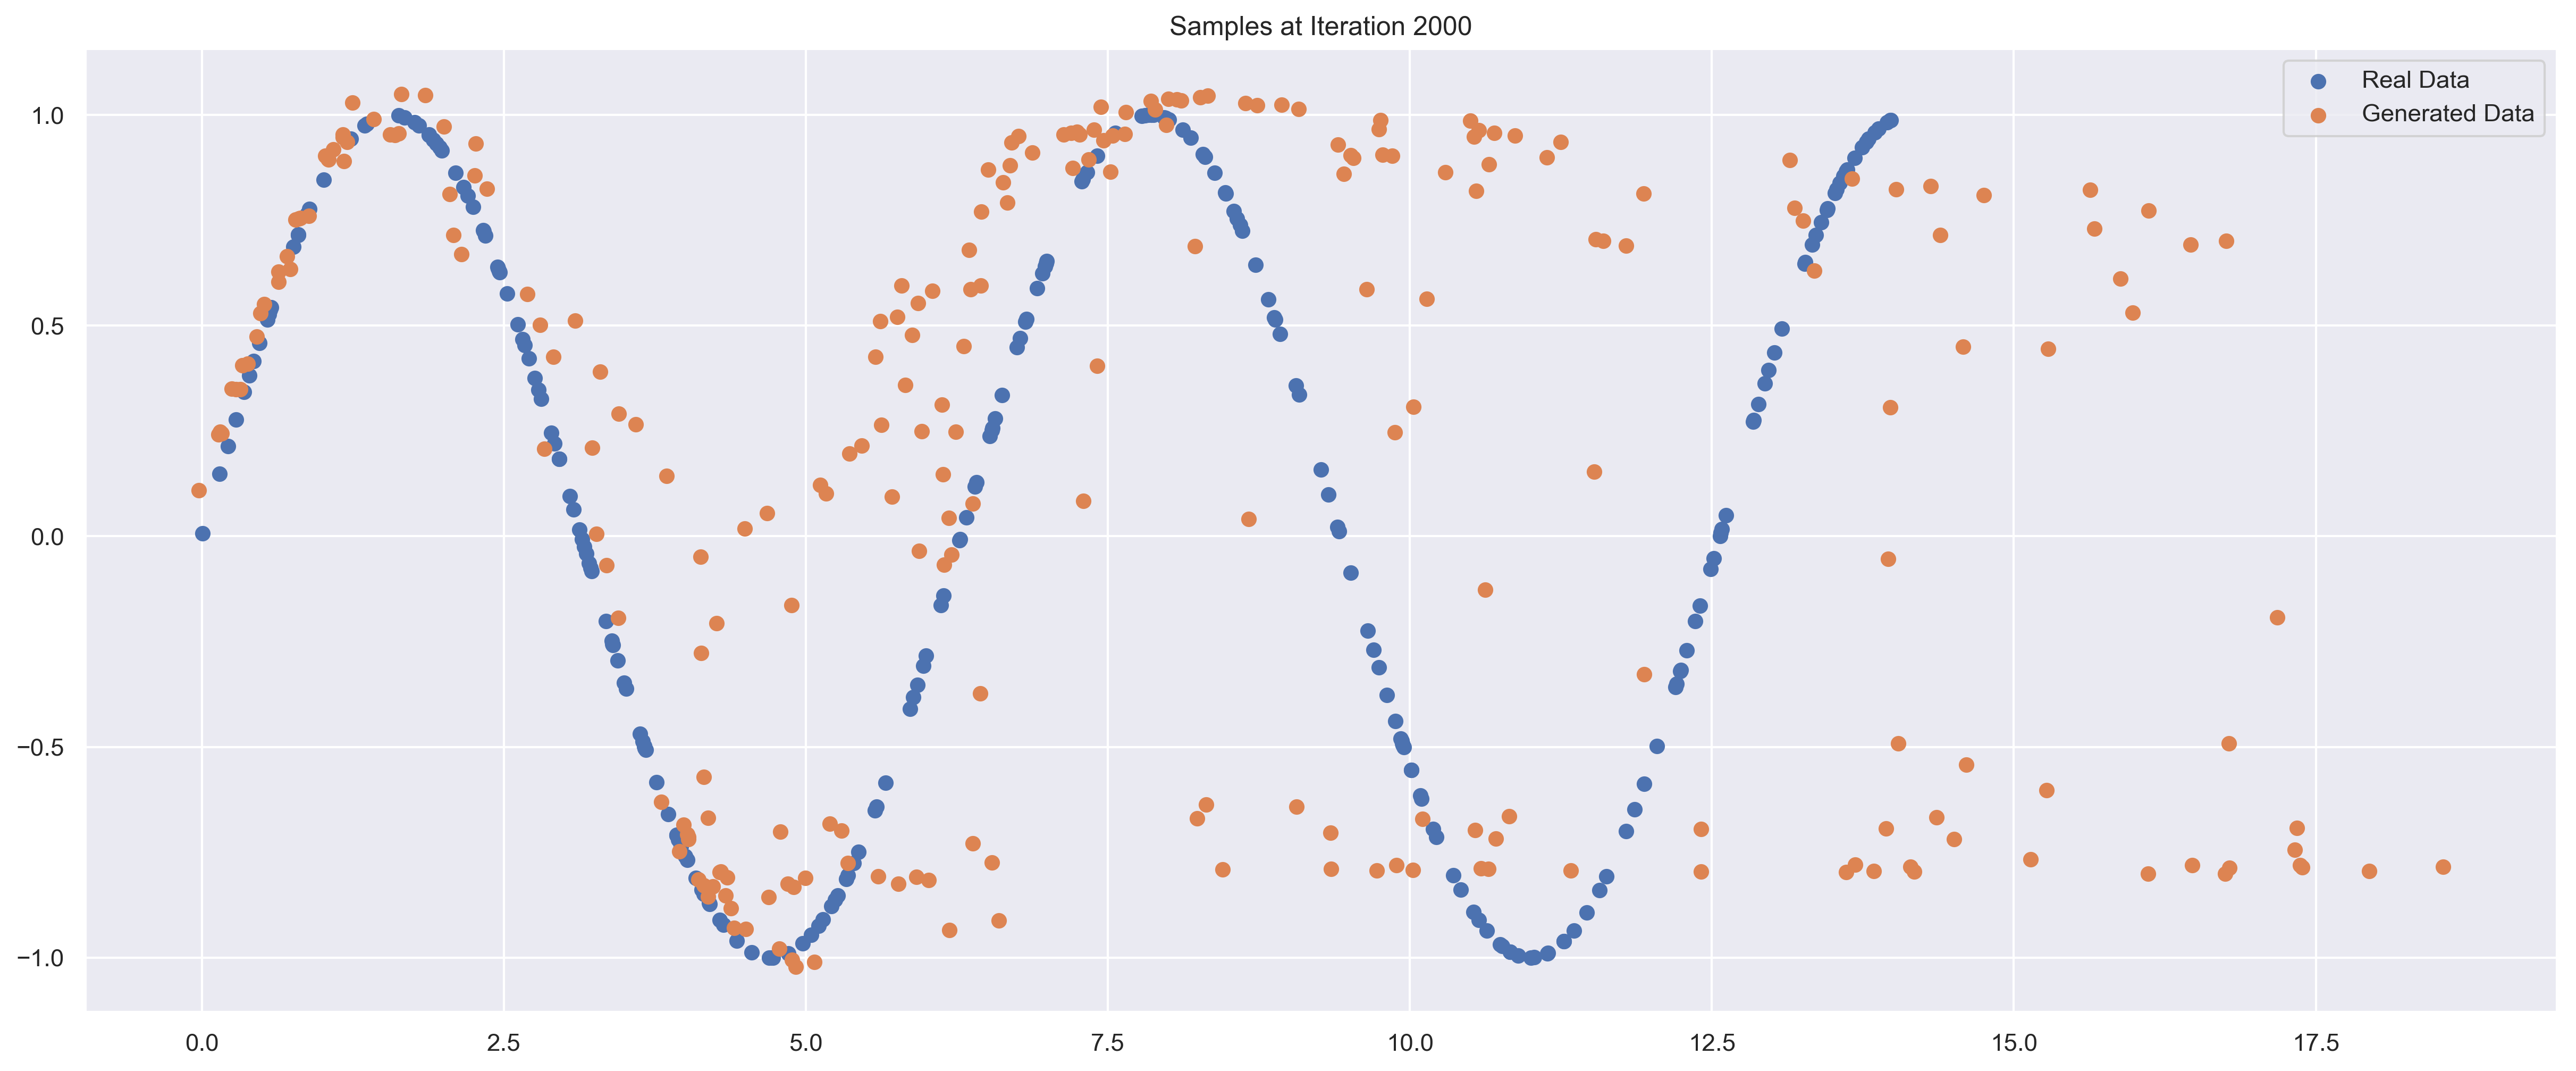

Iterations: 2500	 Discriminator loss: 1.3632	 Generator loss: 0.6160


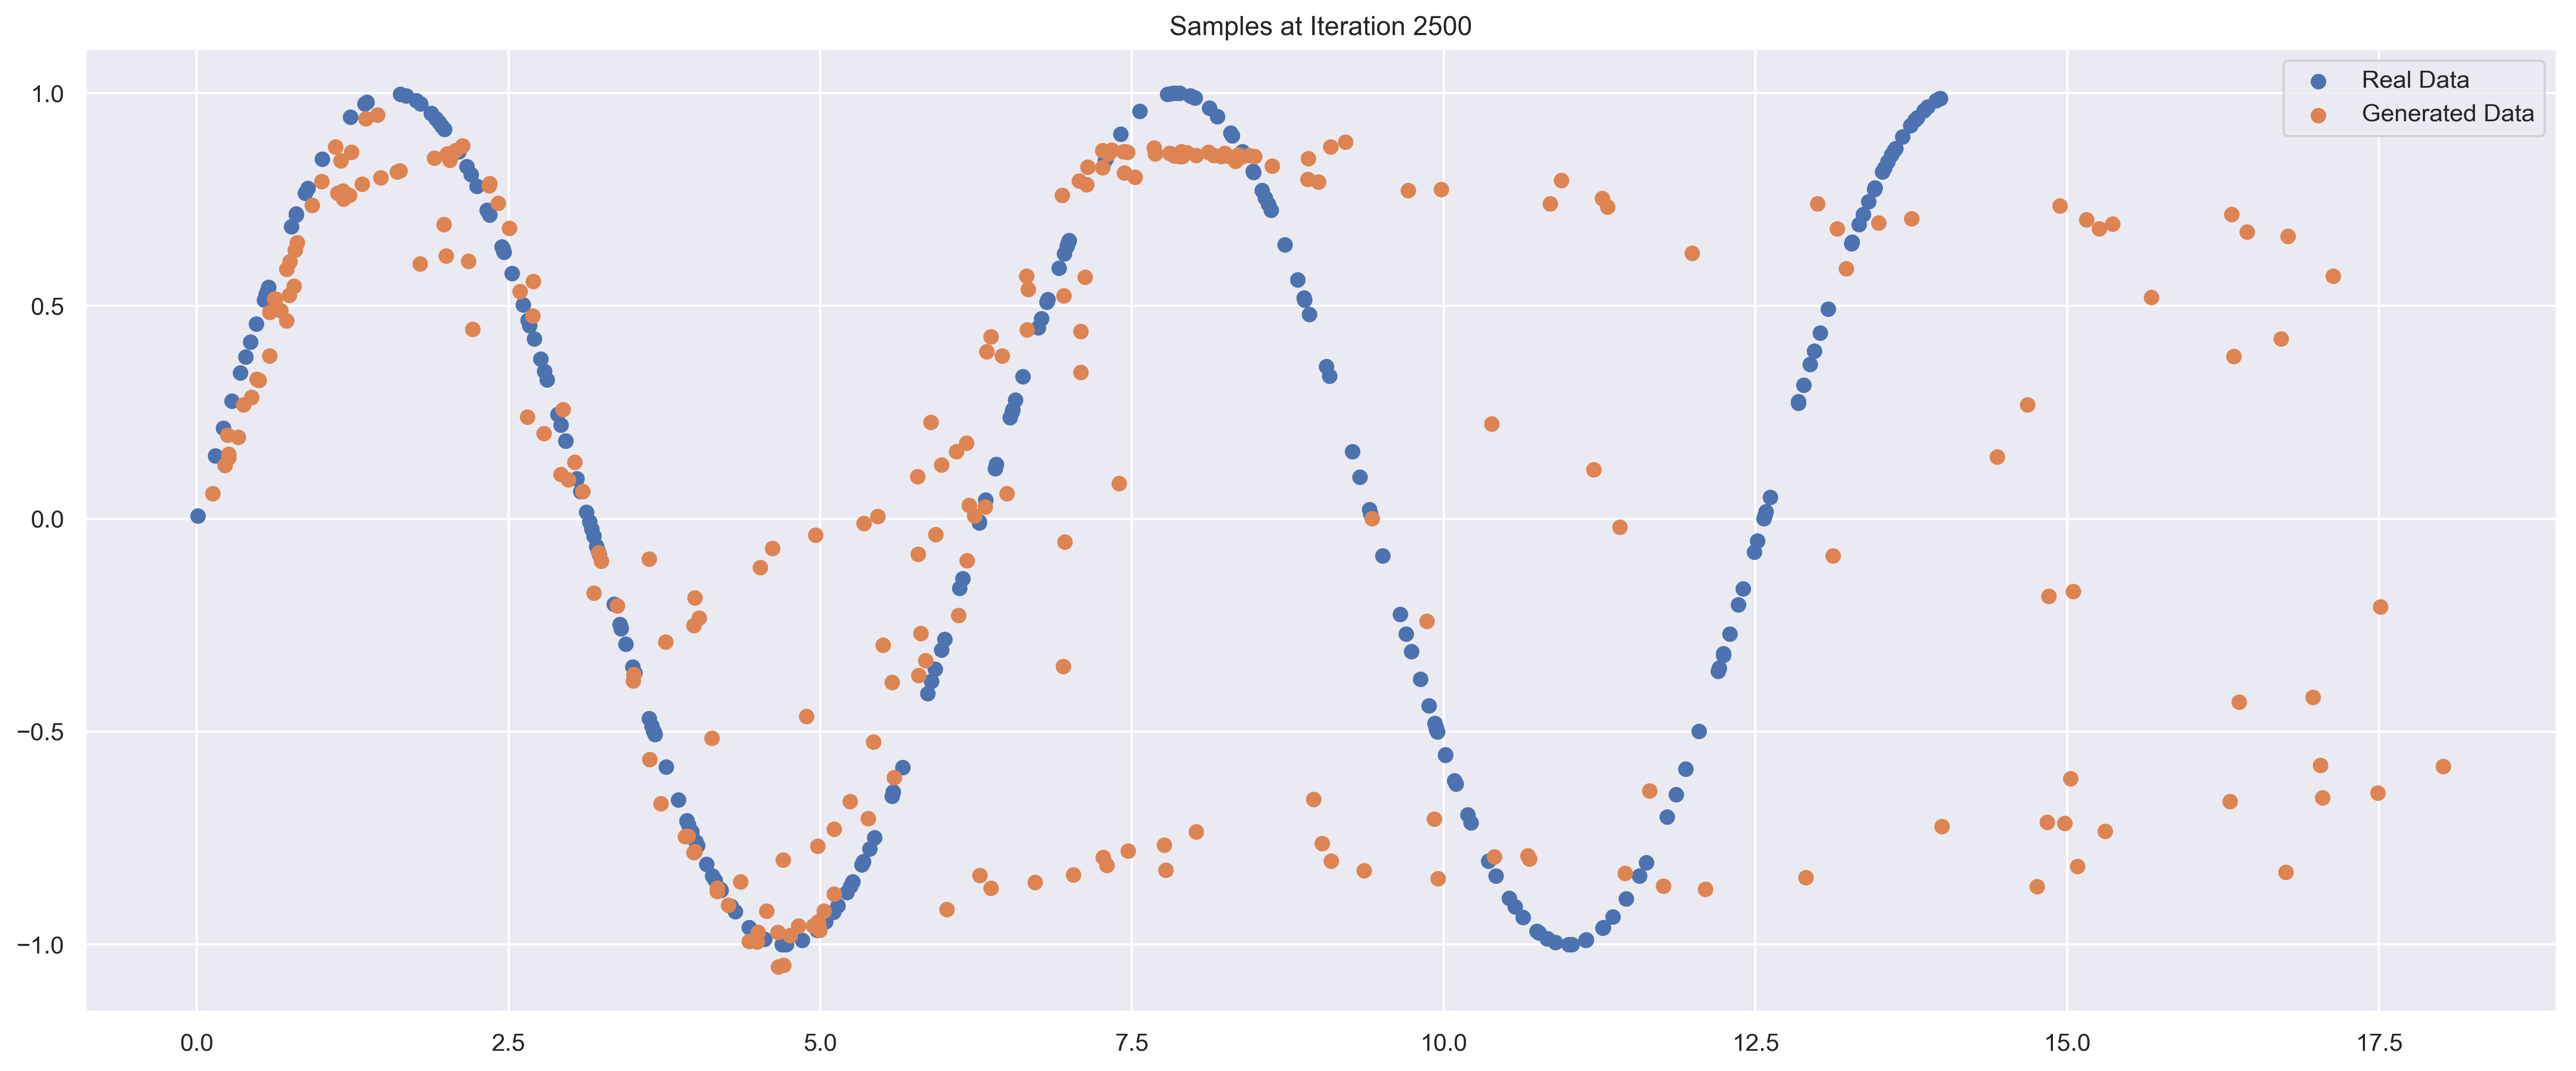

Iterations: 3000	 Discriminator loss: 1.3754	 Generator loss: 0.6144


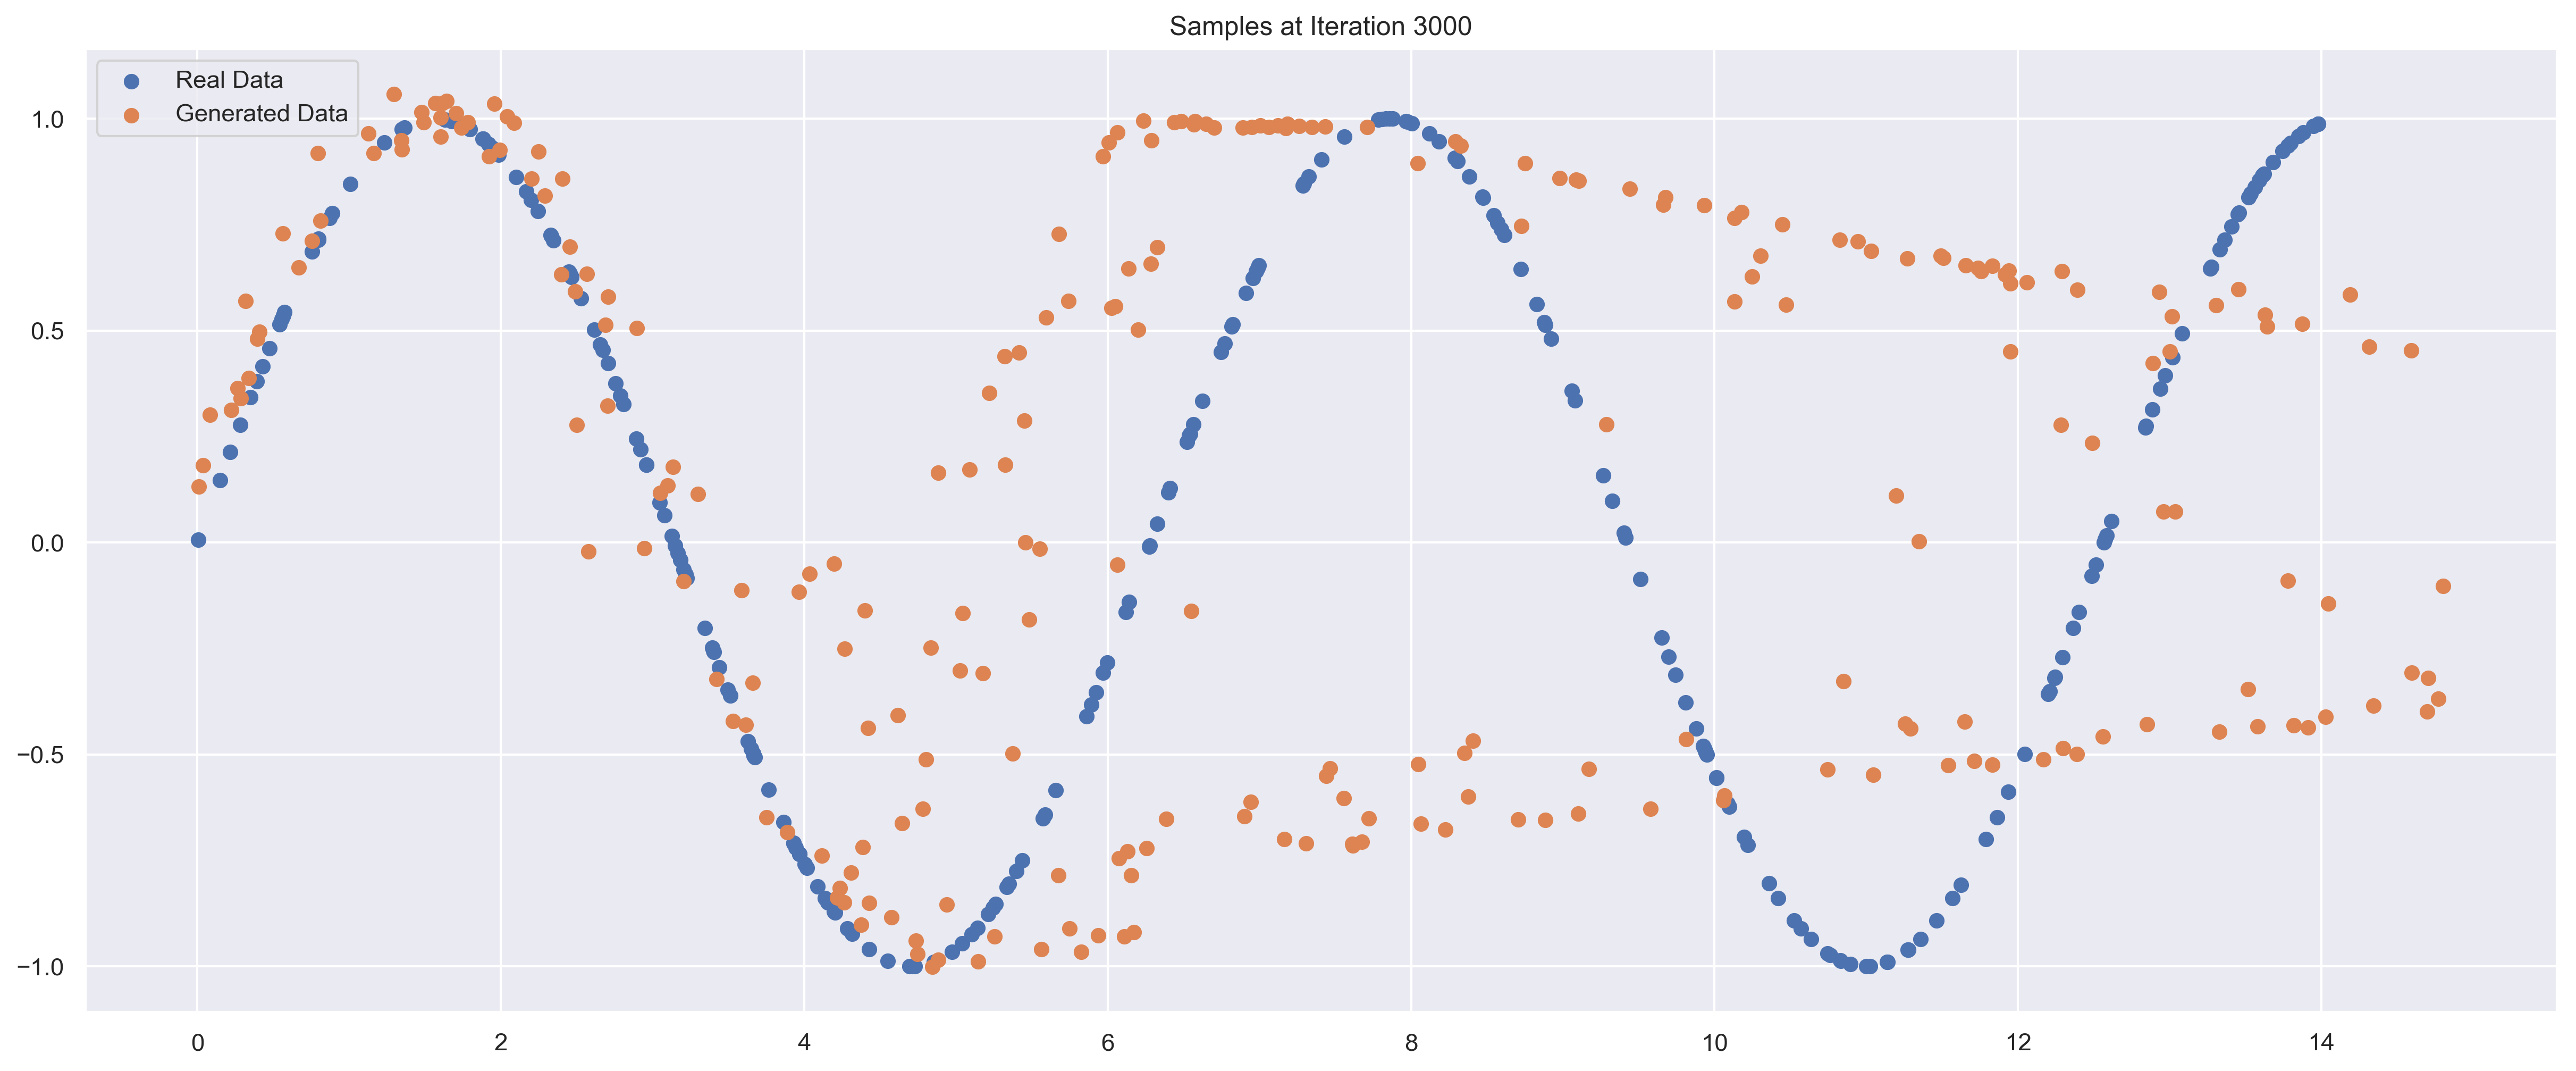

Iterations: 3500	 Discriminator loss: 1.3663	 Generator loss: 0.8172


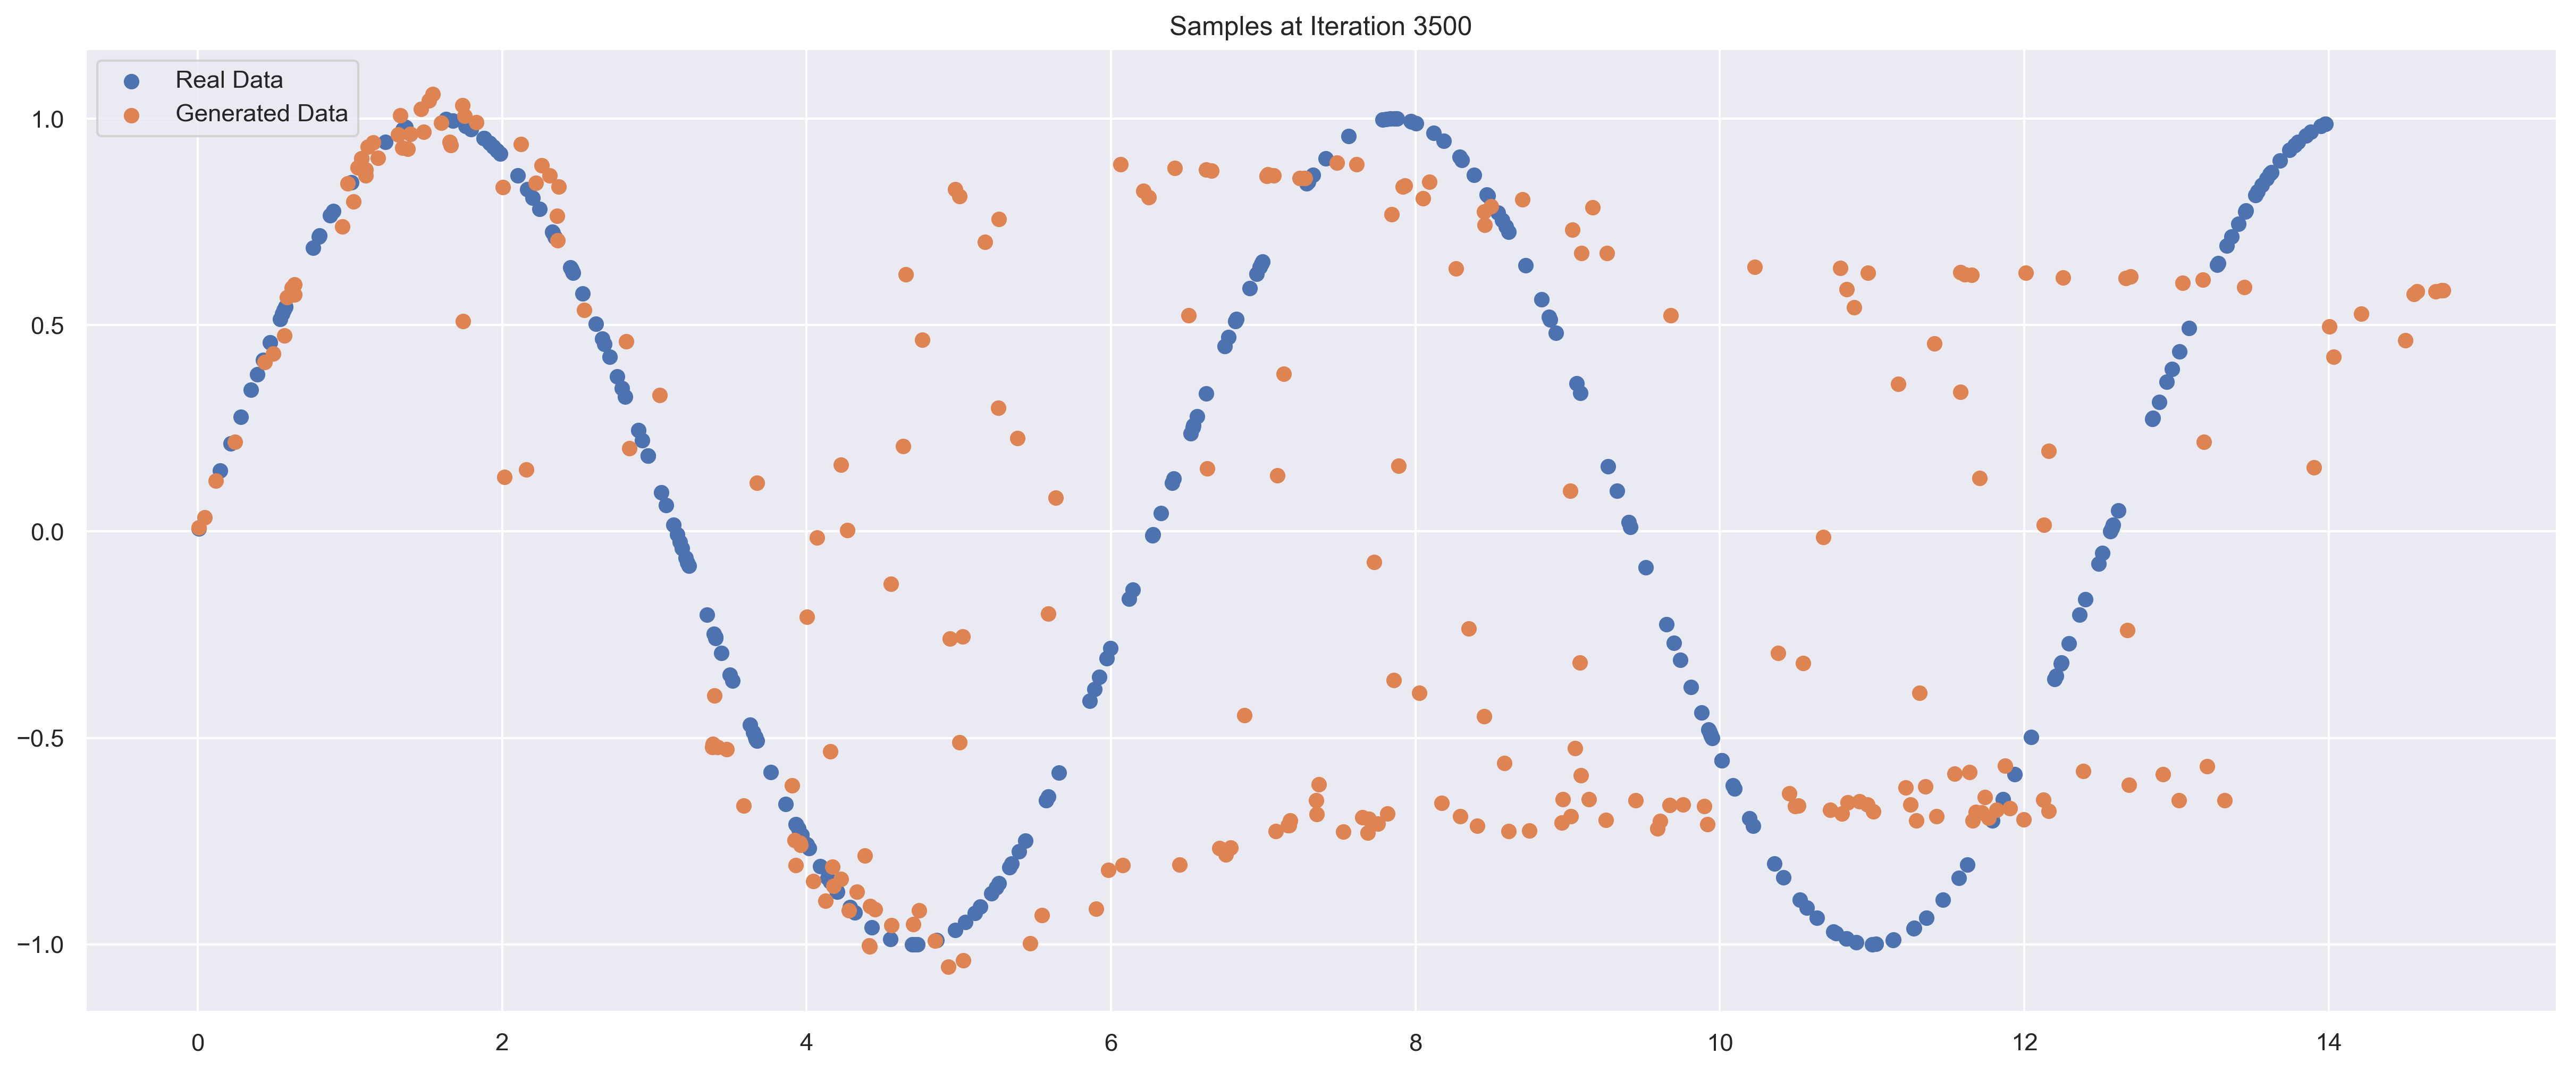

Iterations: 4000	 Discriminator loss: 1.3525	 Generator loss: 0.6171


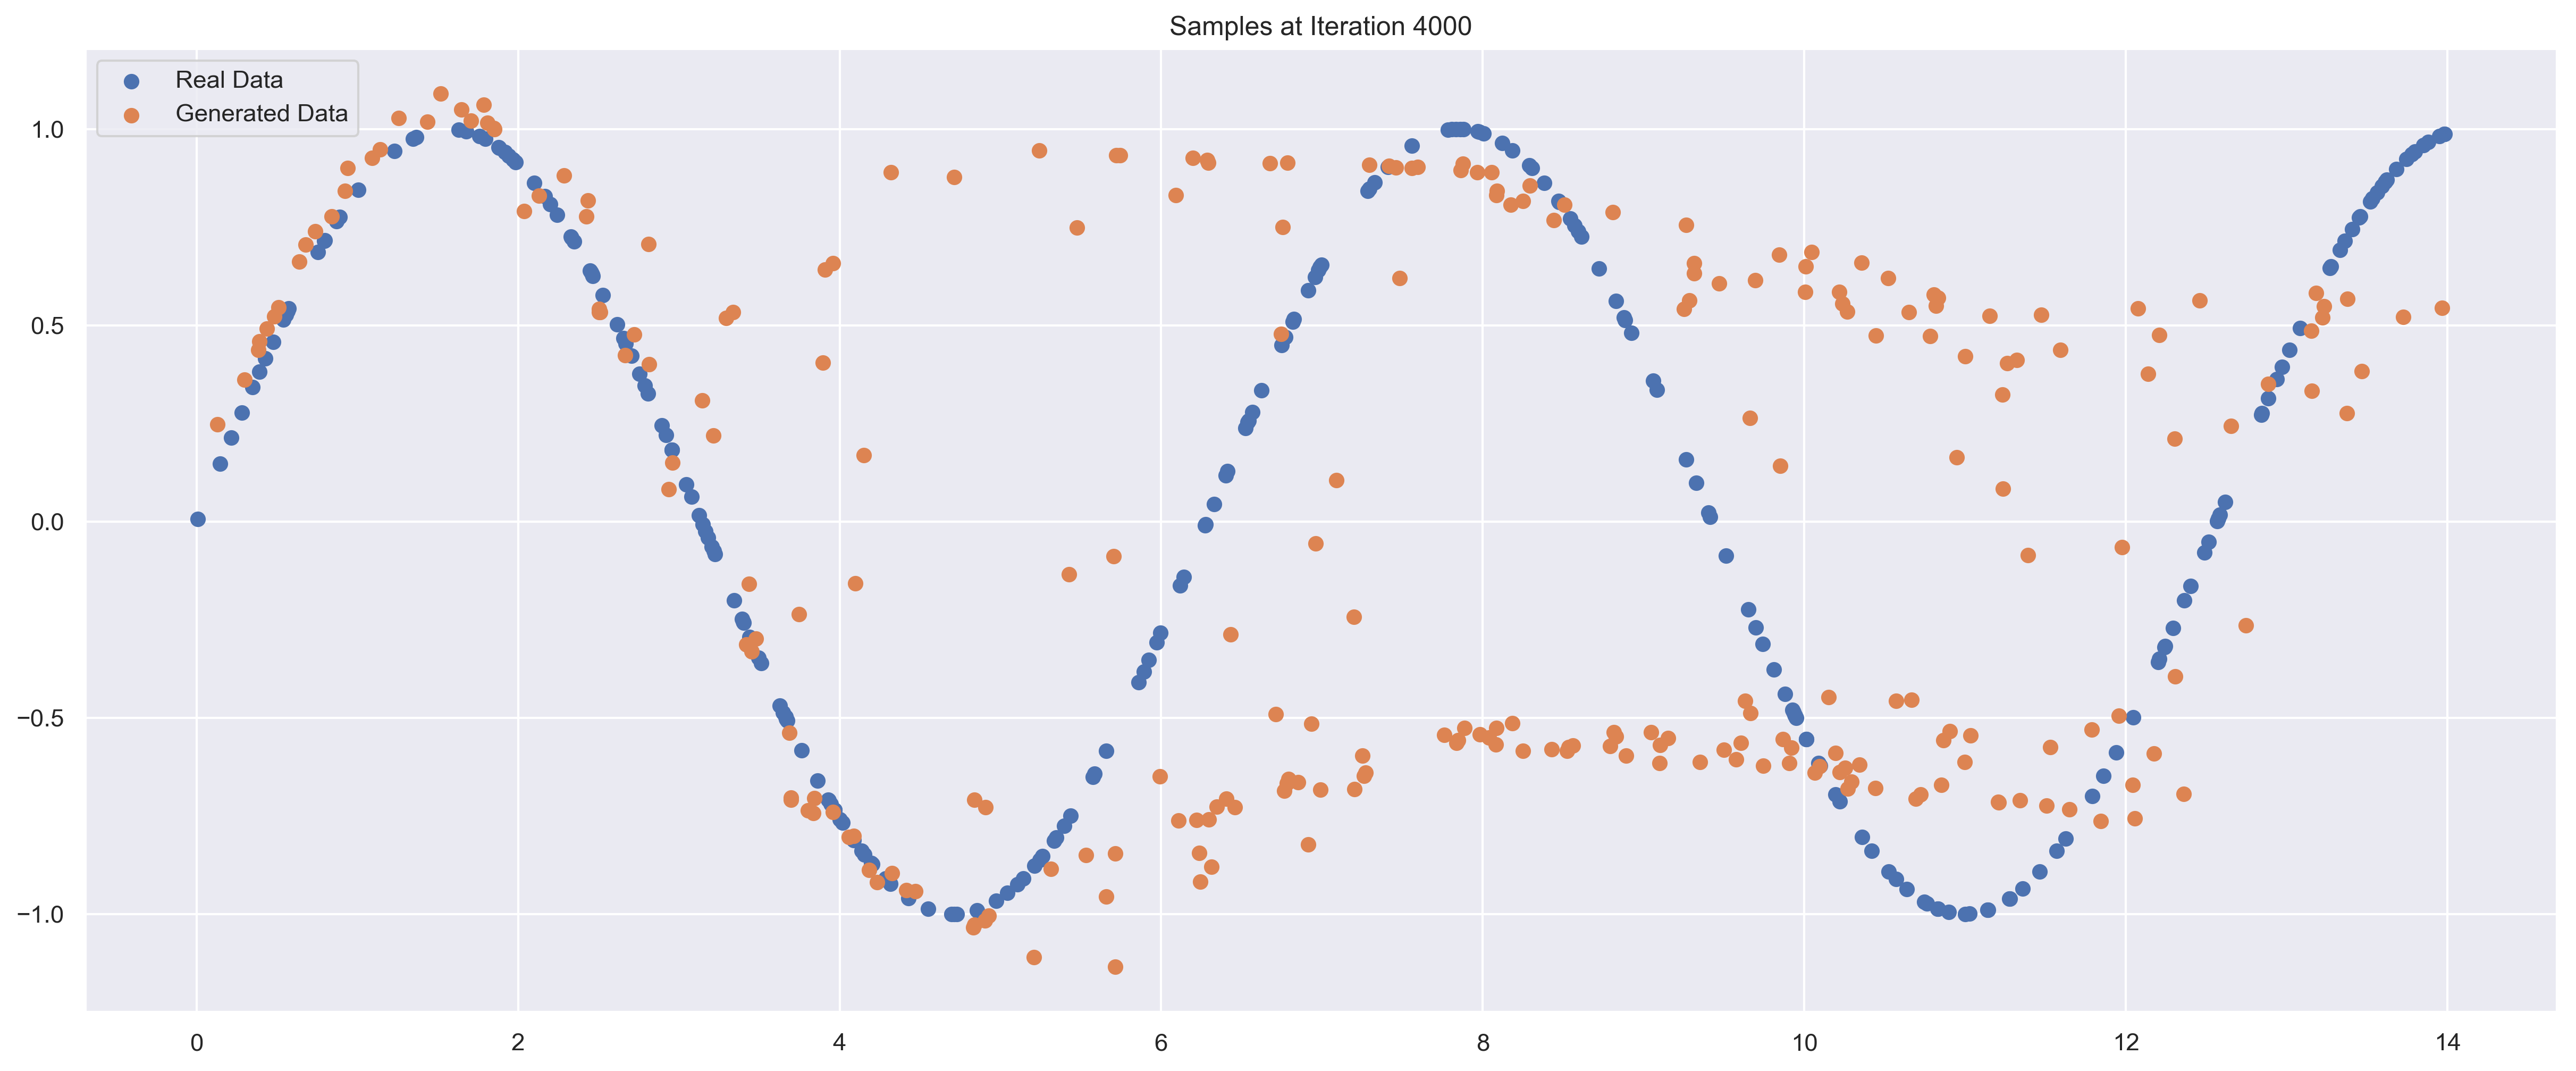

Iterations: 4500	 Discriminator loss: 1.3677	 Generator loss: 0.6114


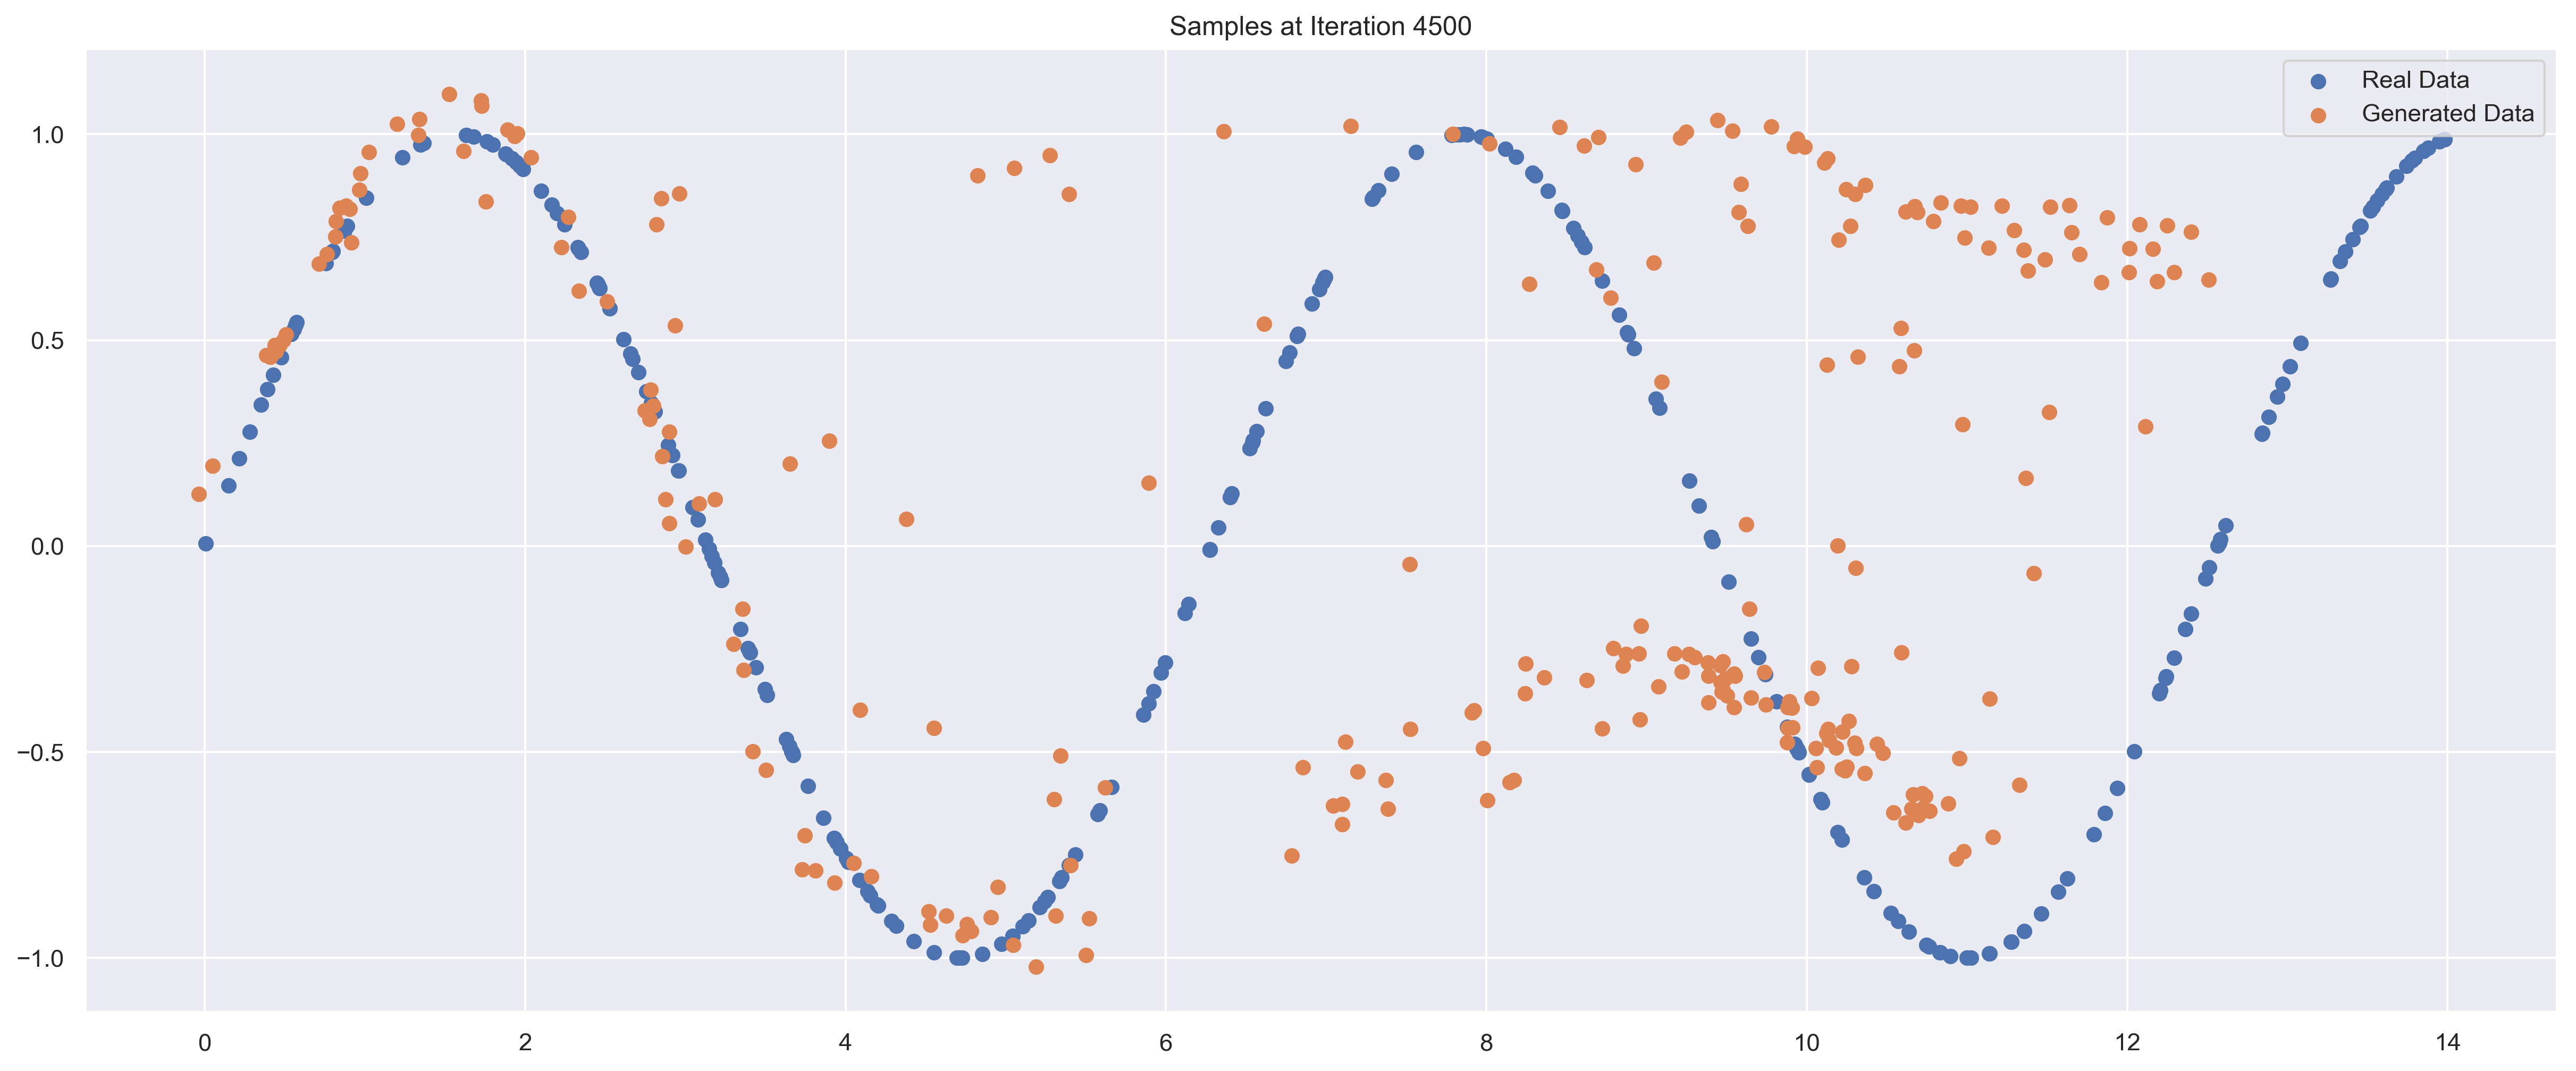

Iterations: 5000	 Discriminator loss: 1.3394	 Generator loss: 0.6243


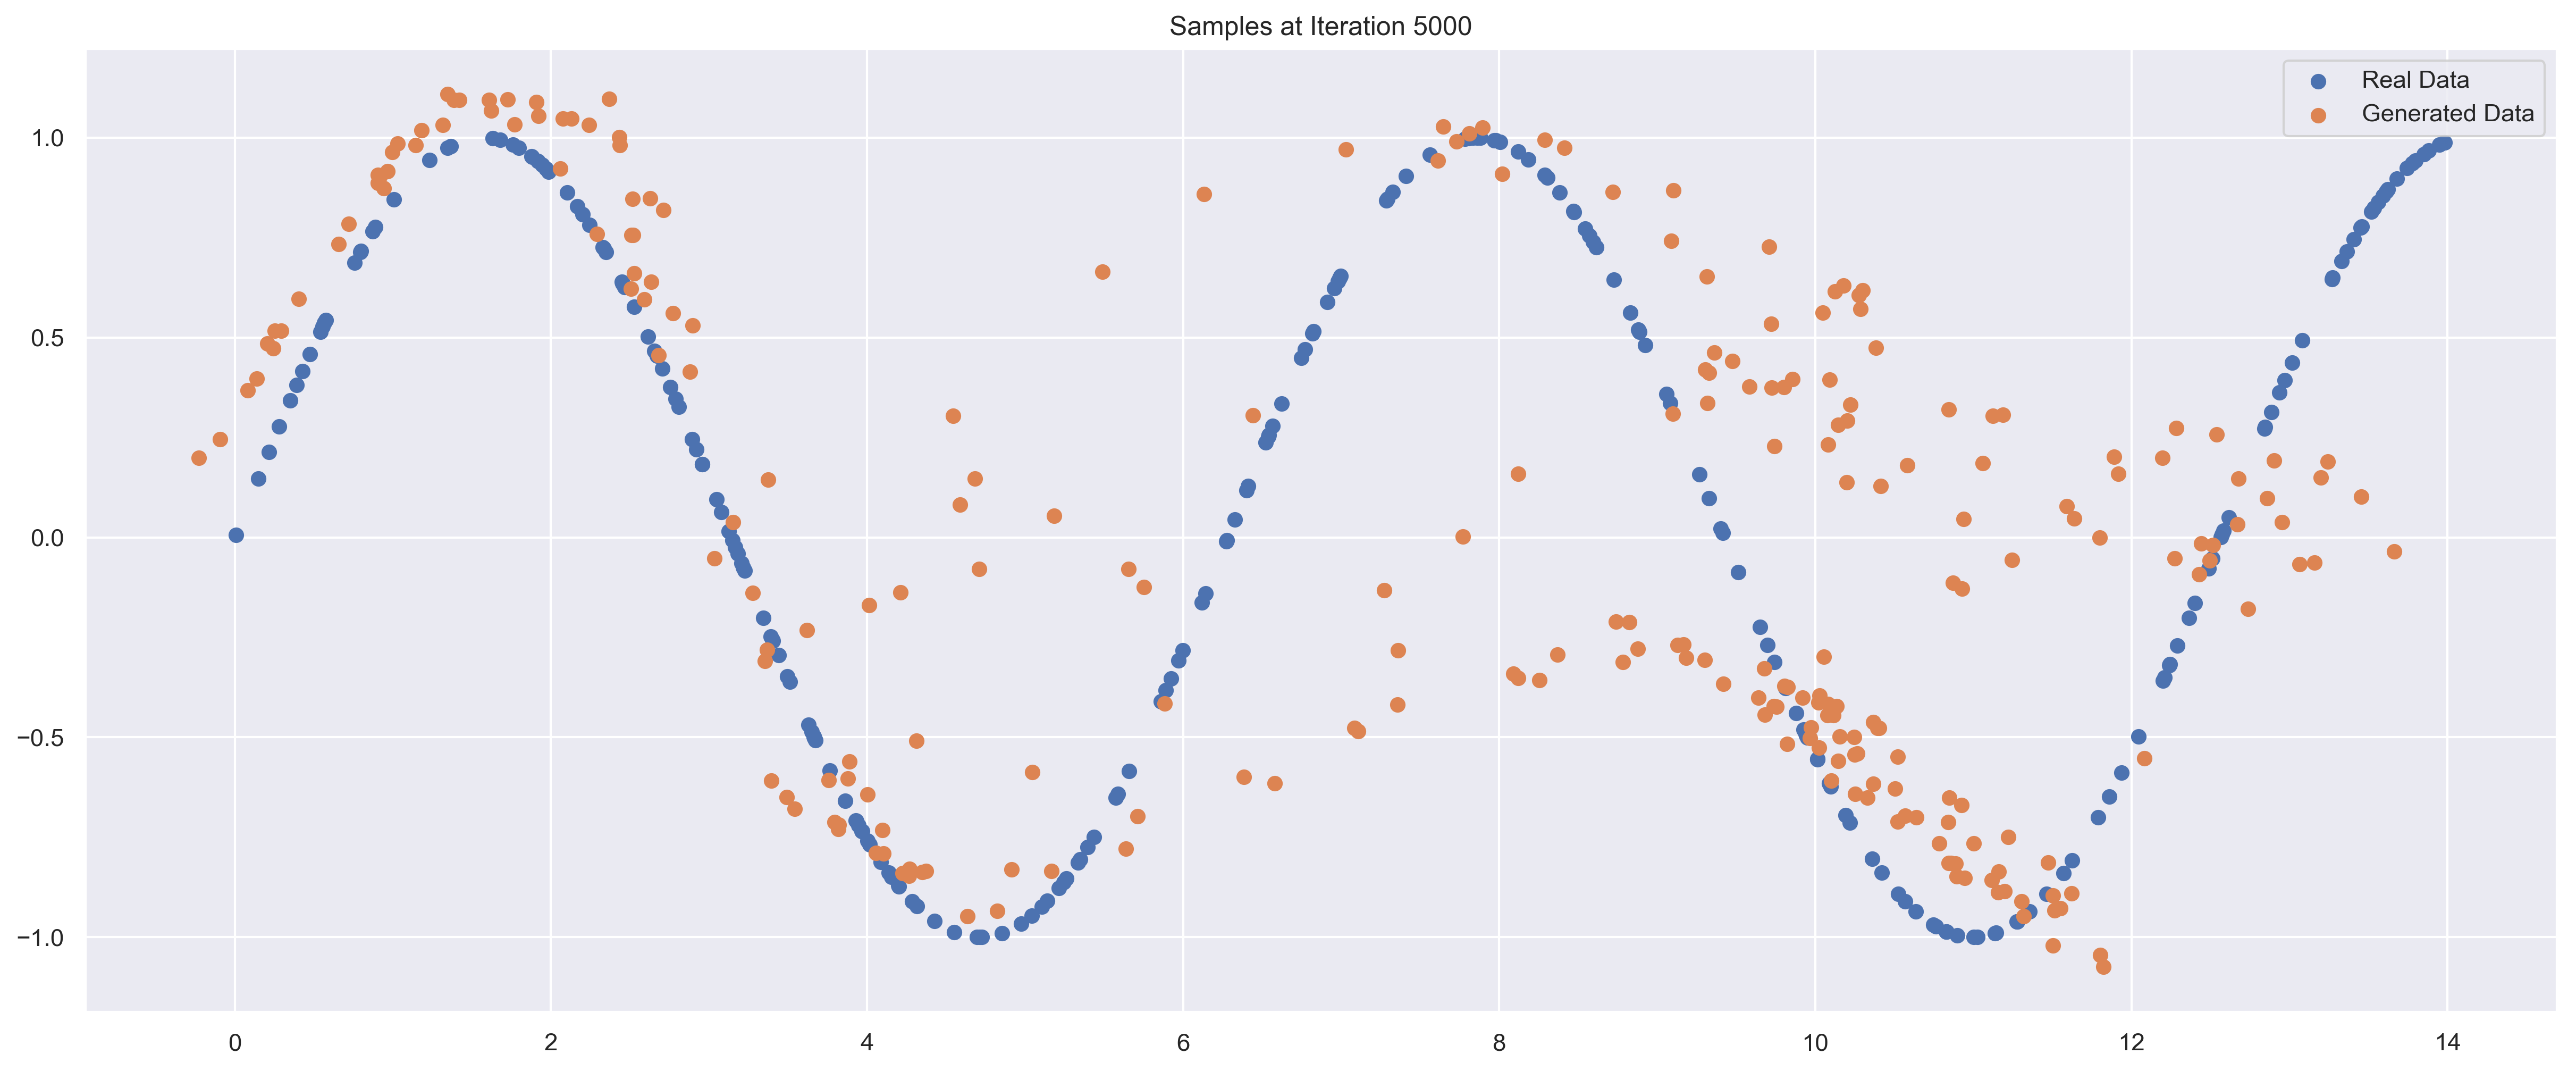

Iterations: 5500	 Discriminator loss: 1.2871	 Generator loss: 0.5835


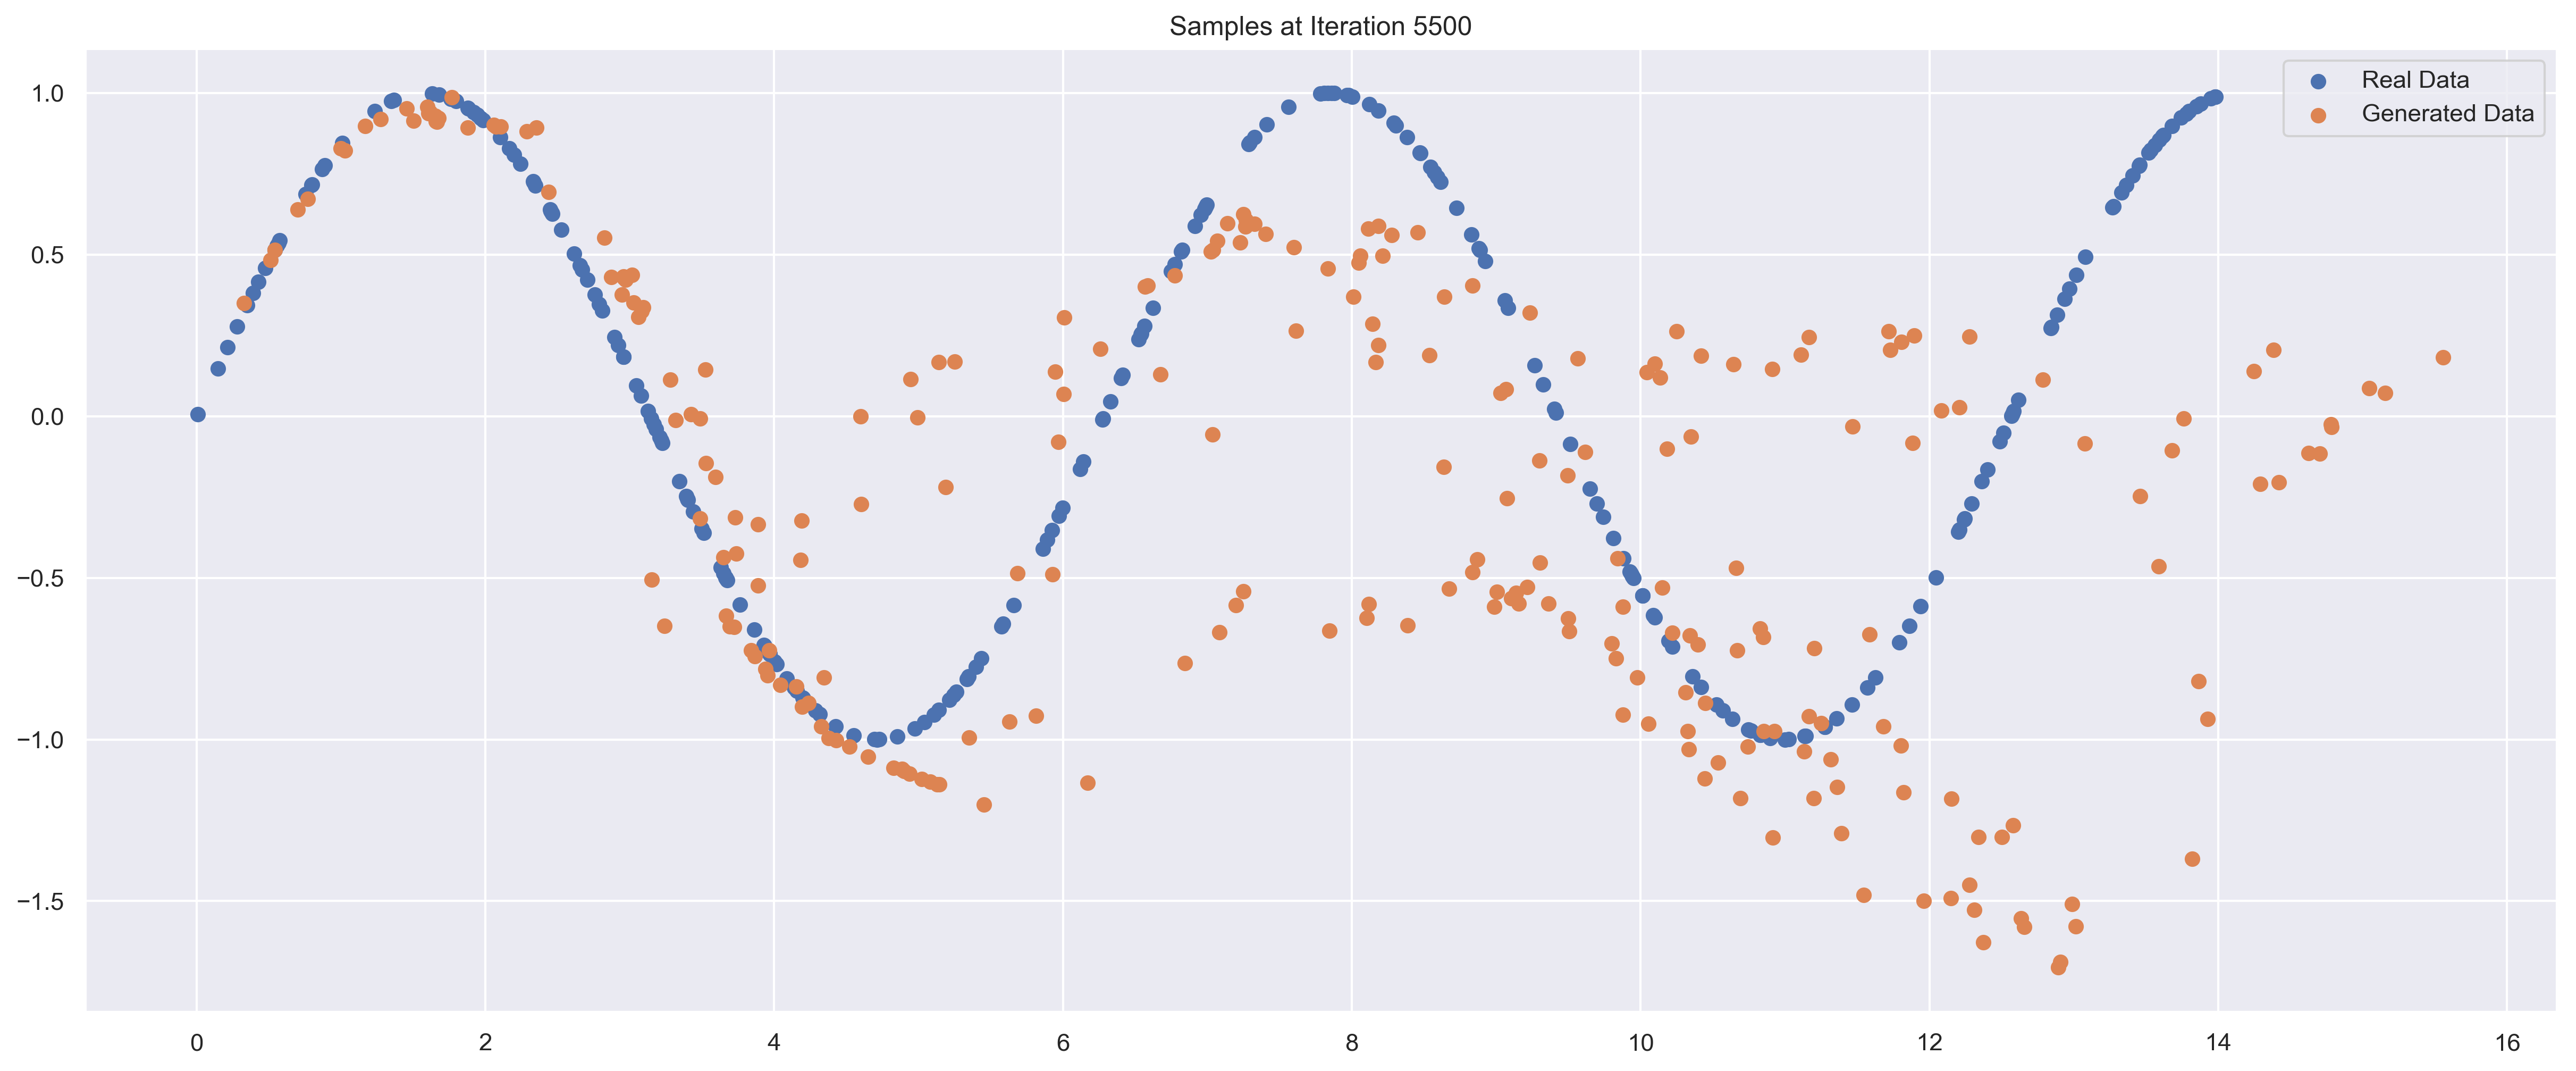

Iterations: 6000	 Discriminator loss: 1.2897	 Generator loss: 0.6251


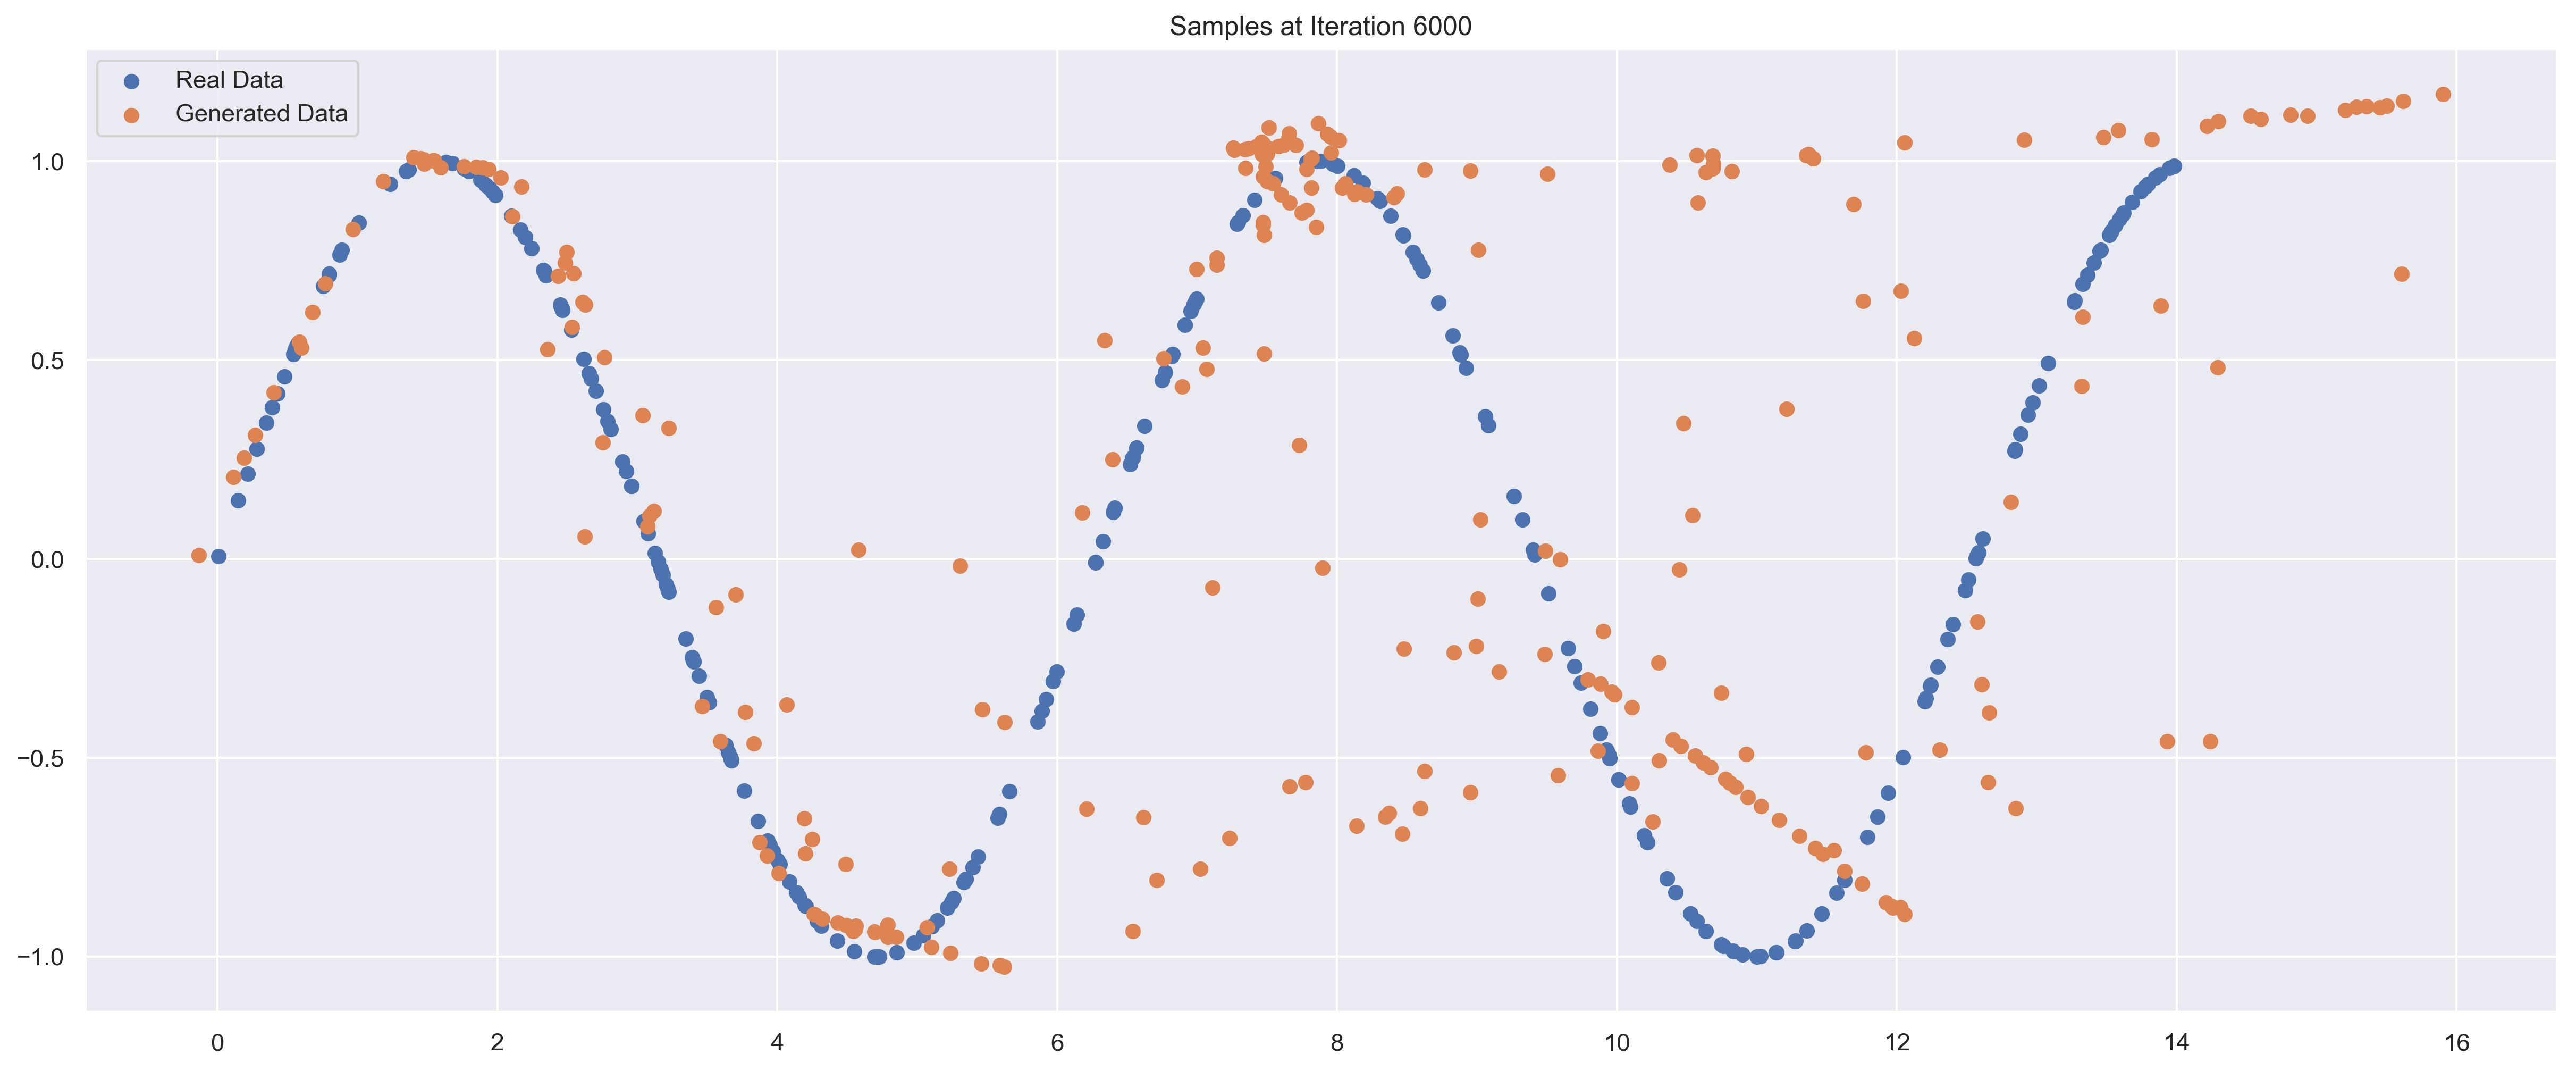

Iterations: 6500	 Discriminator loss: 1.3265	 Generator loss: 0.5962


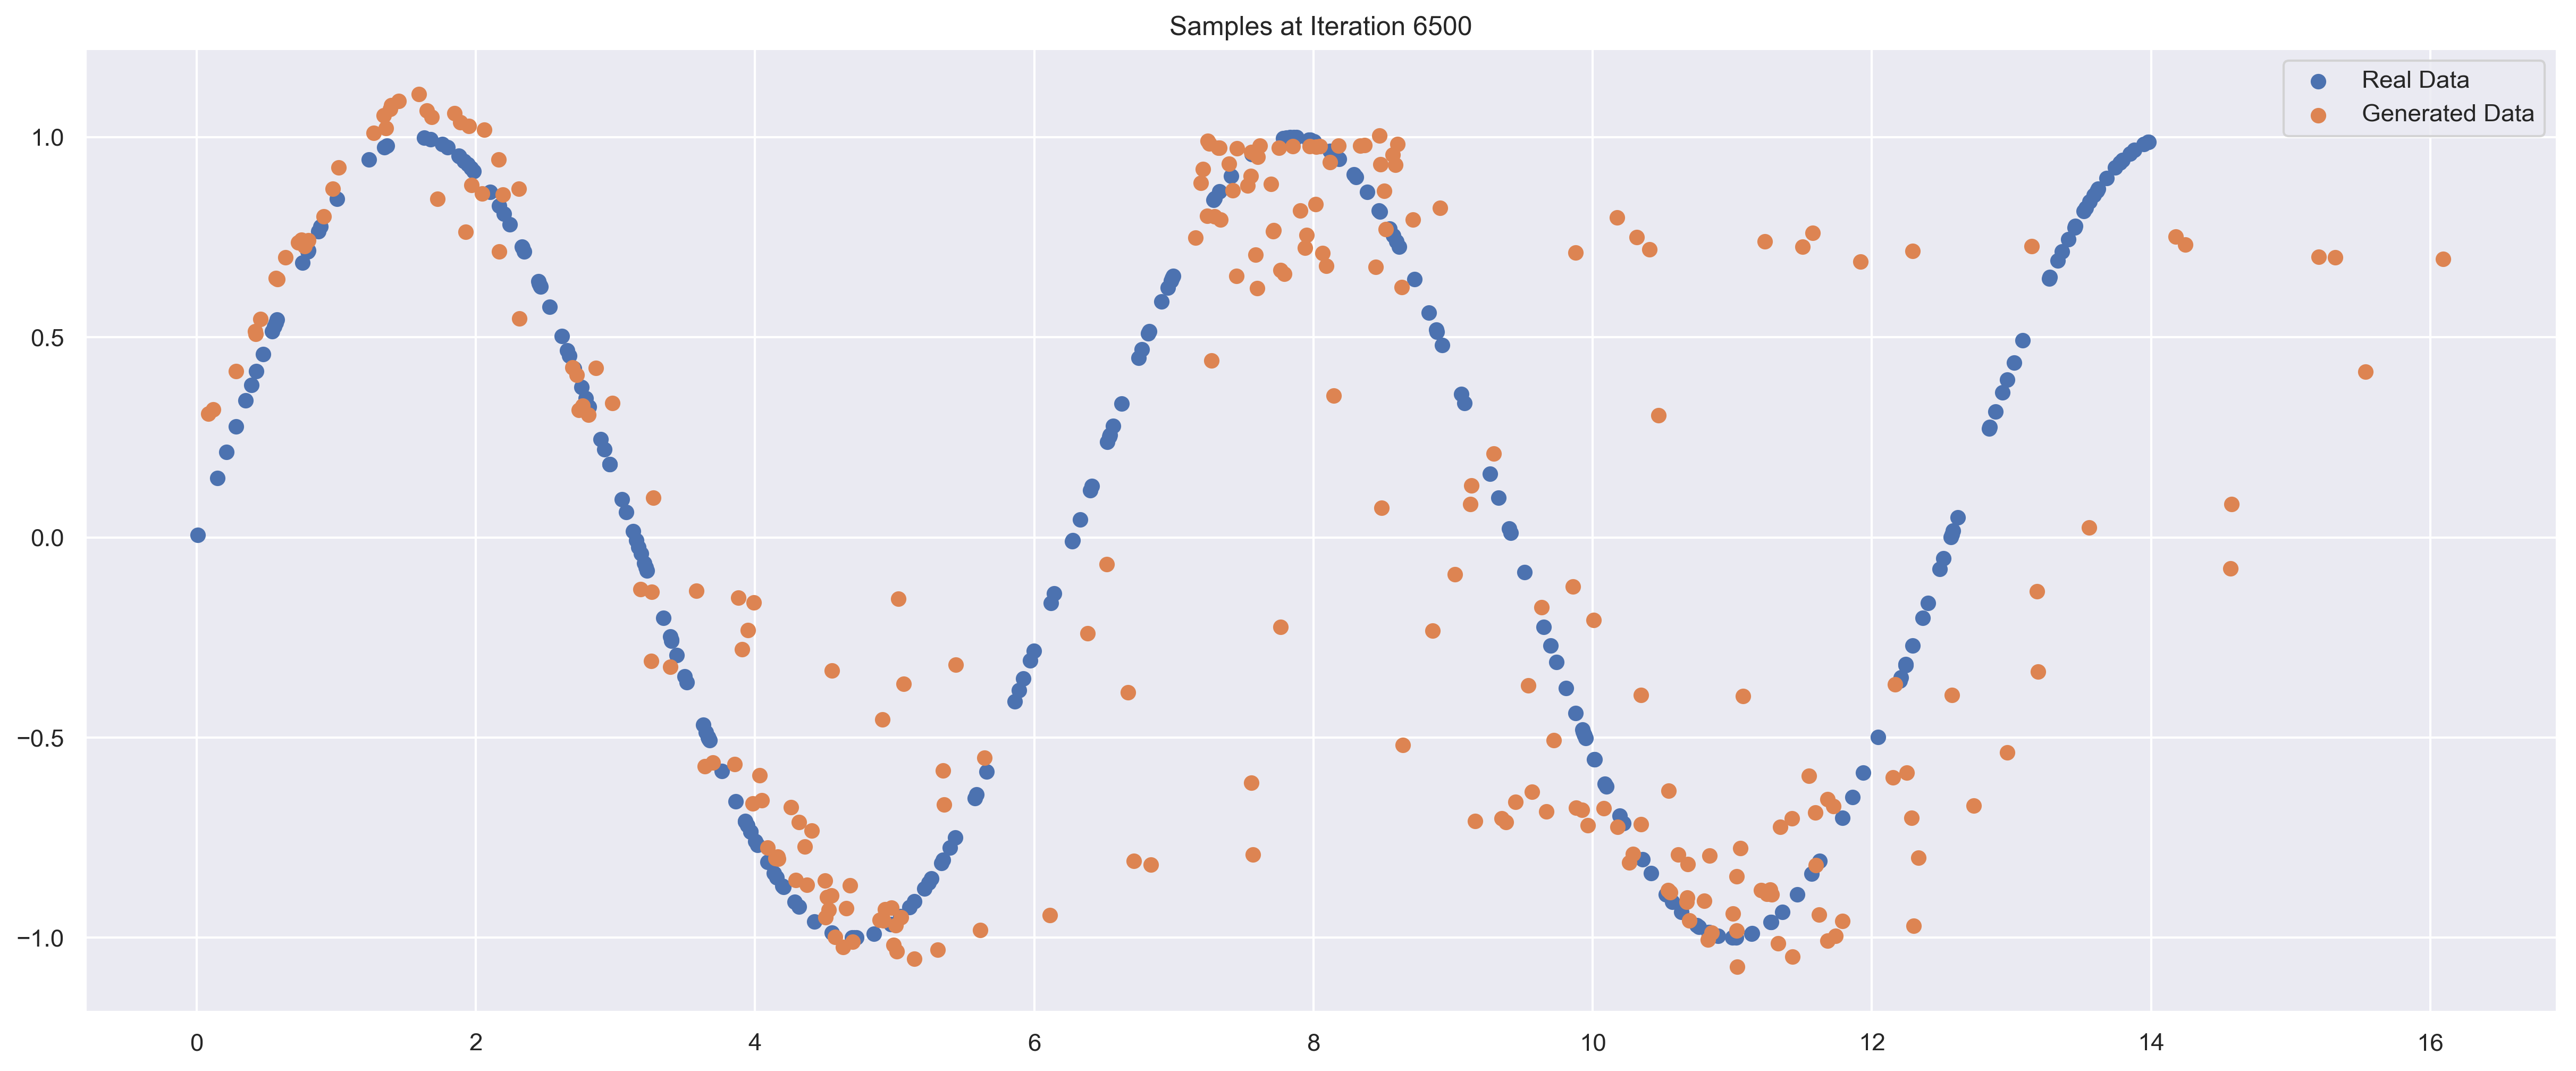

Iterations: 7000	 Discriminator loss: 1.3025	 Generator loss: 0.5886


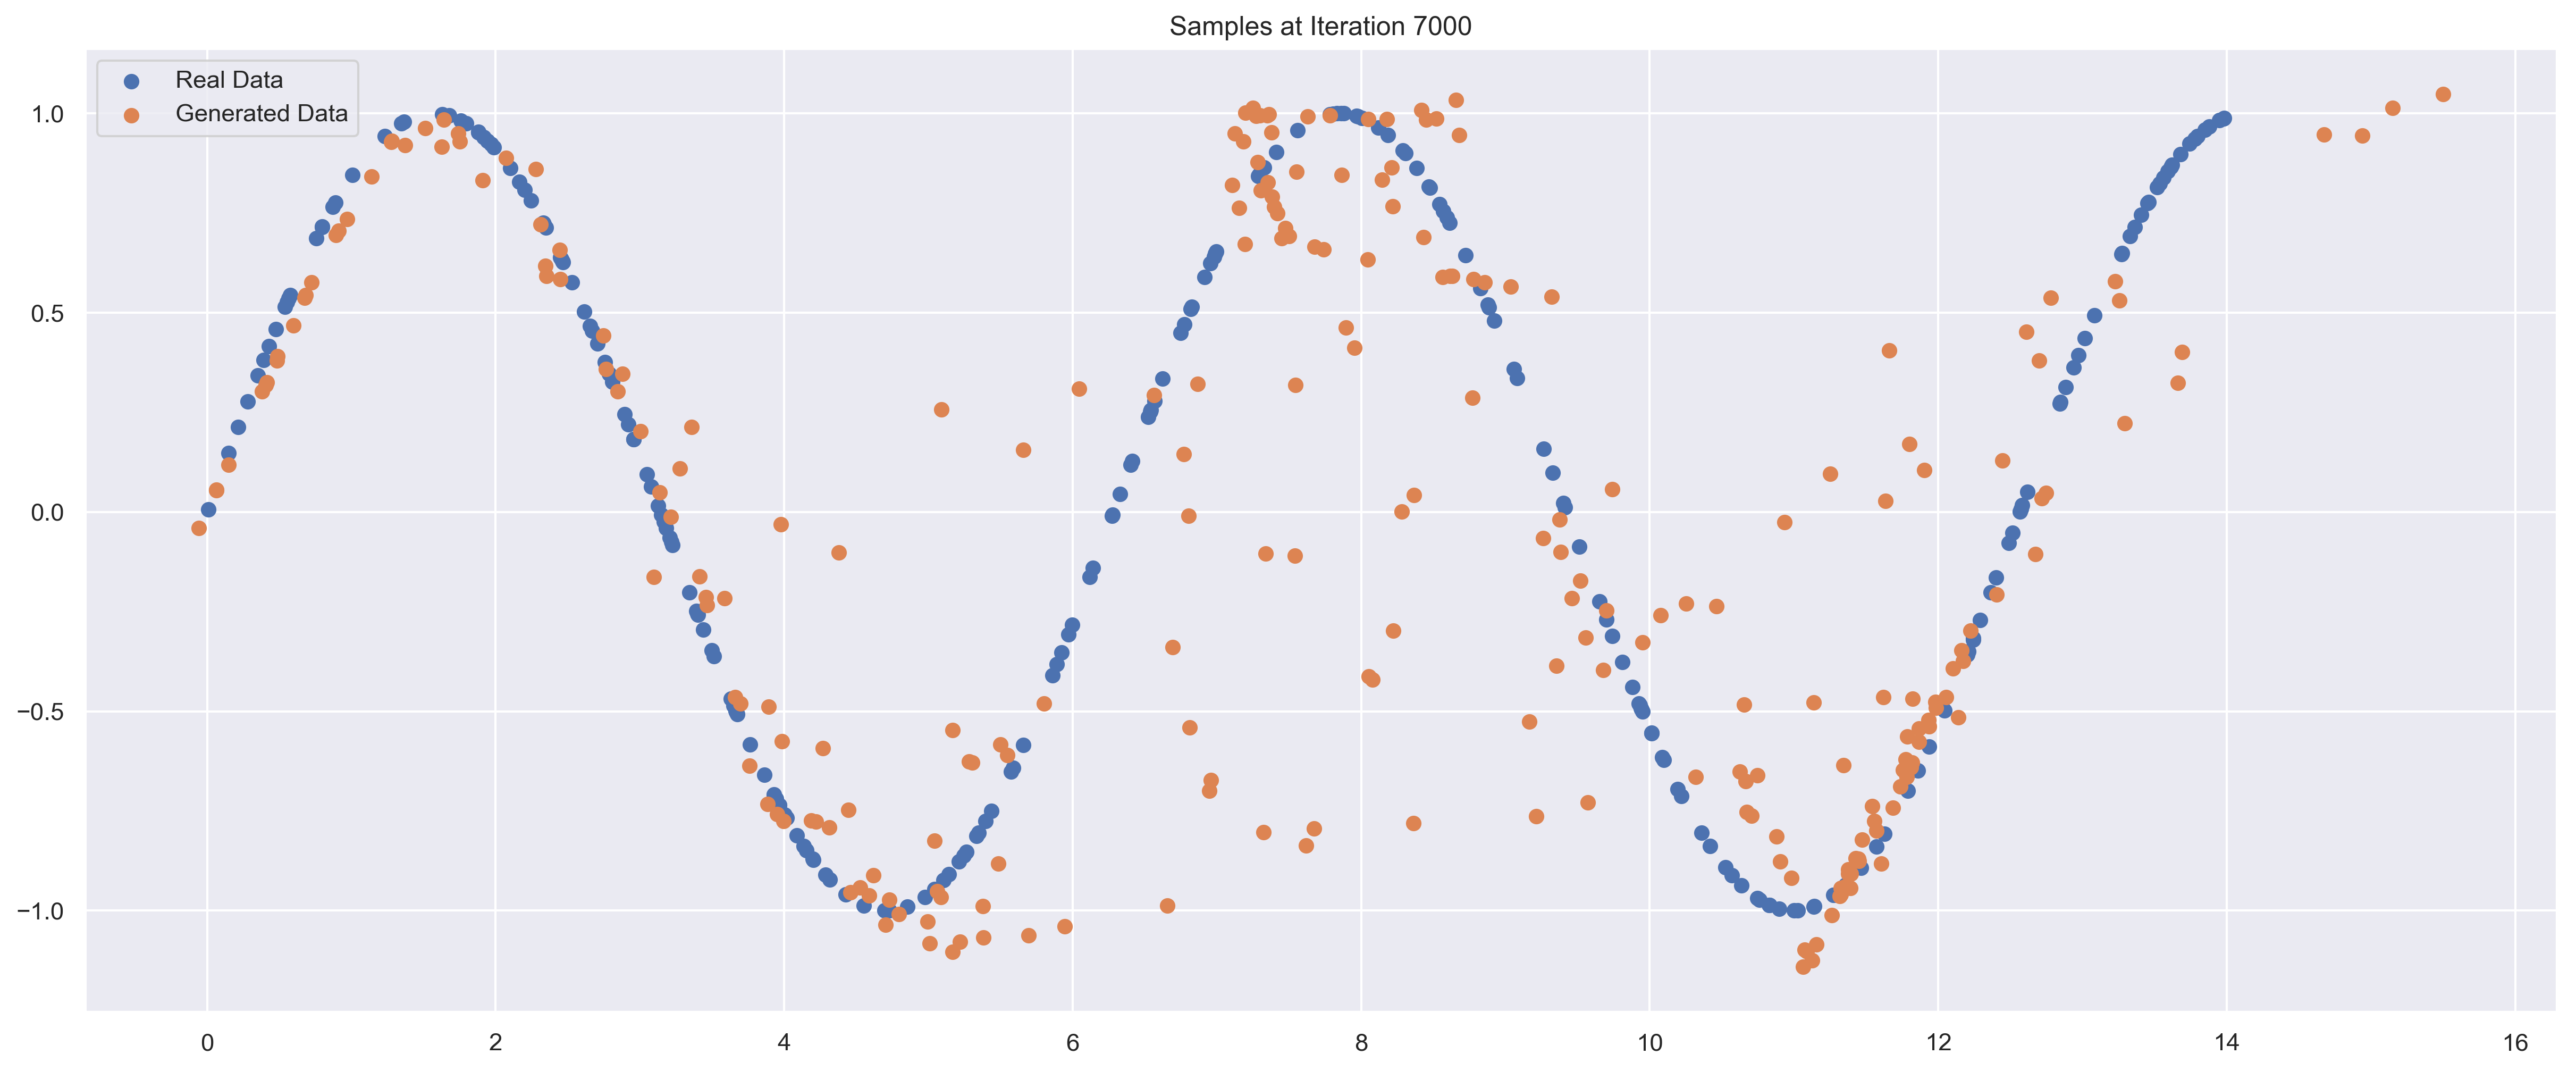

Iterations: 7500	 Discriminator loss: 1.2761	 Generator loss: 0.6217


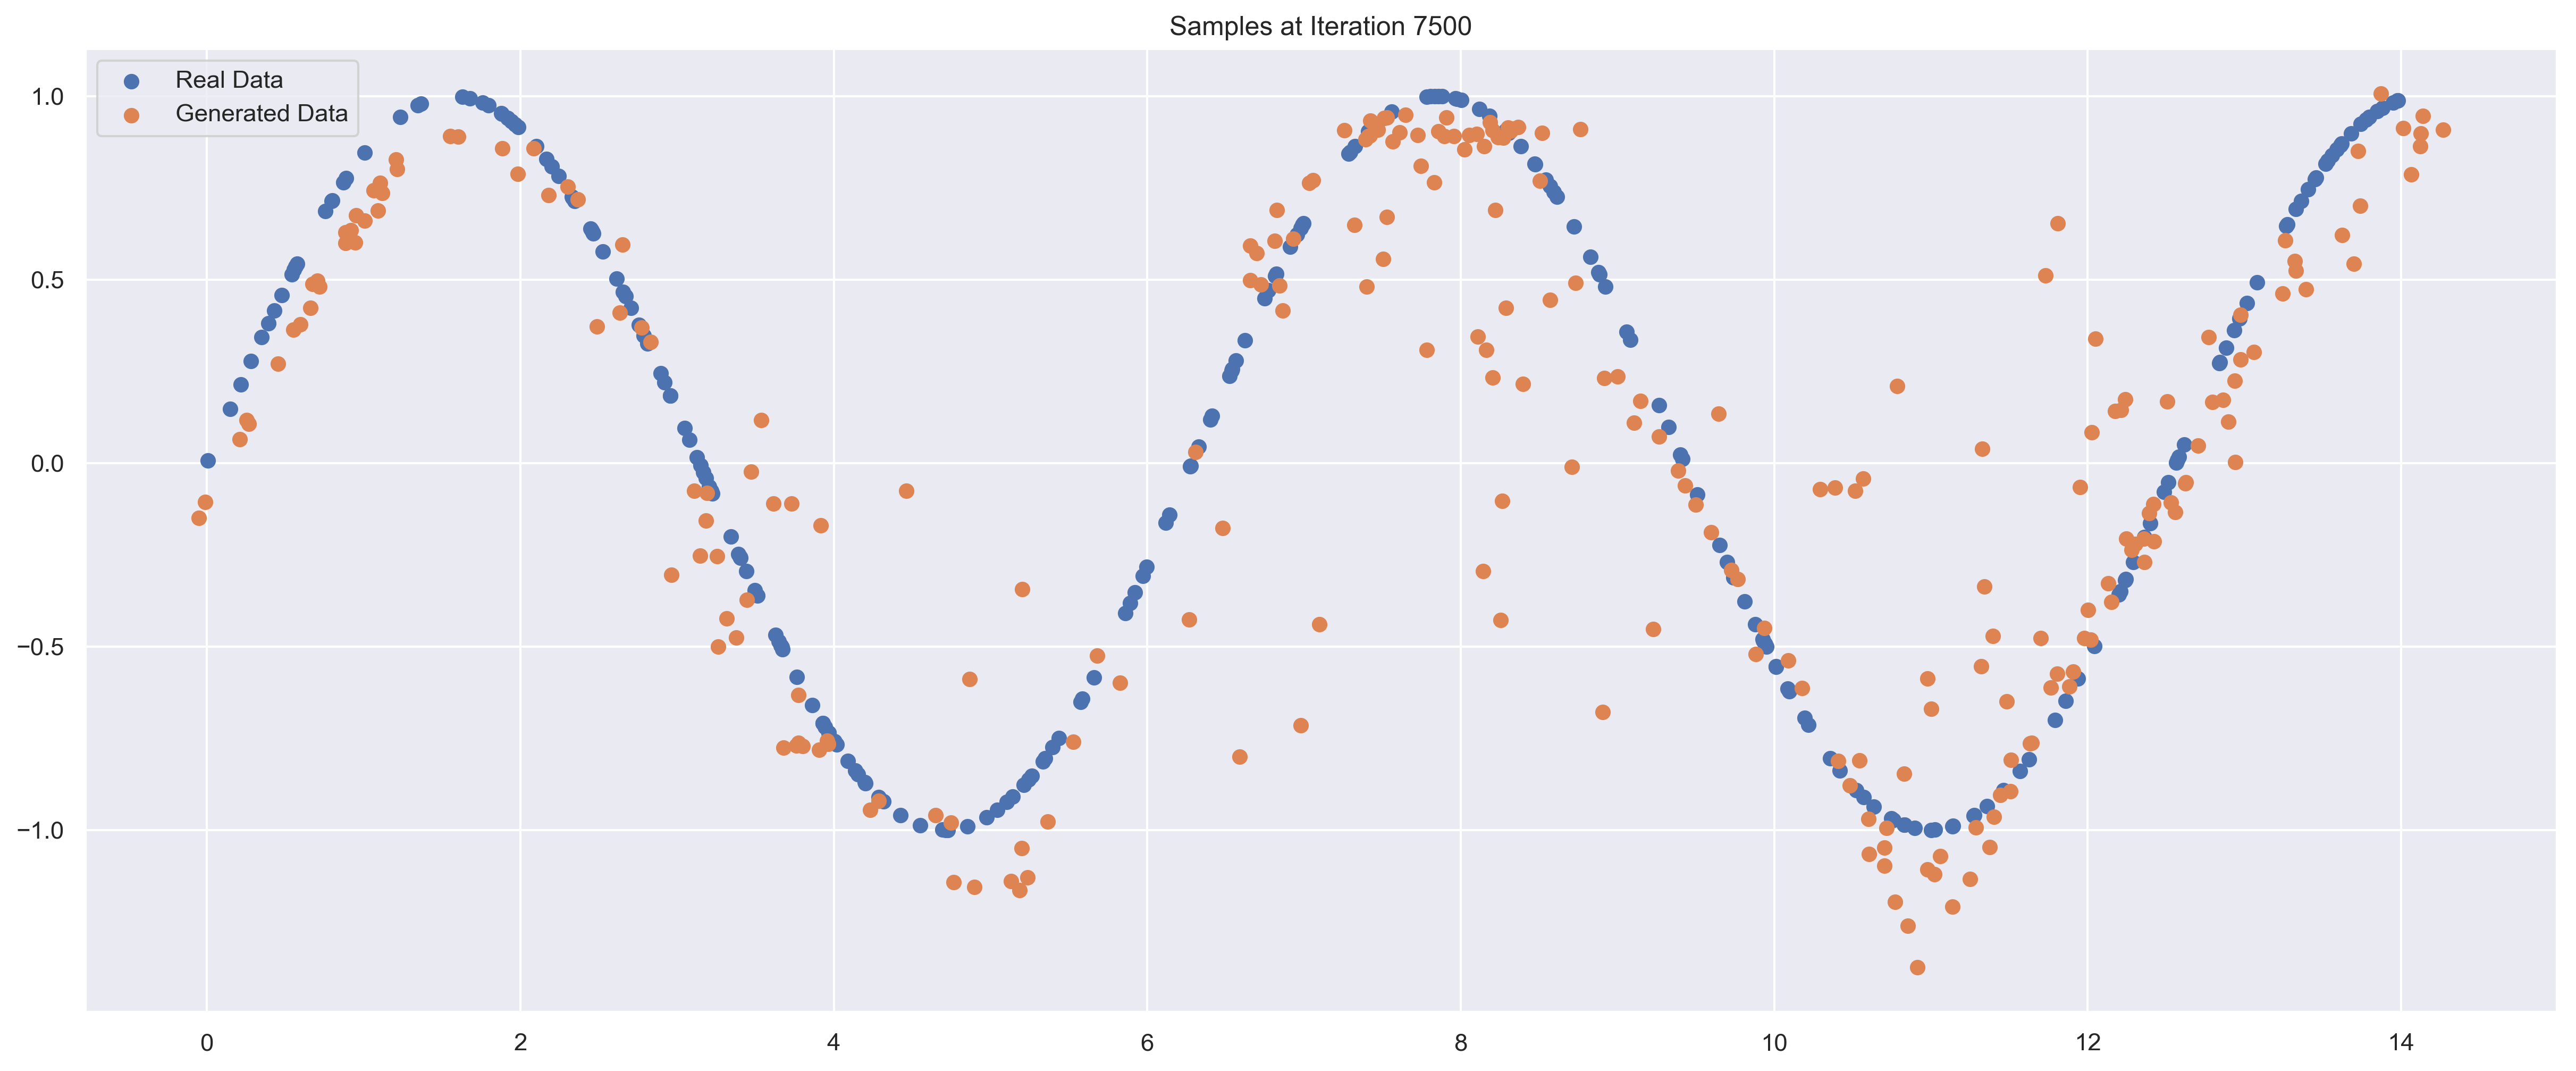

Iterations: 8000	 Discriminator loss: 1.2955	 Generator loss: 0.6105


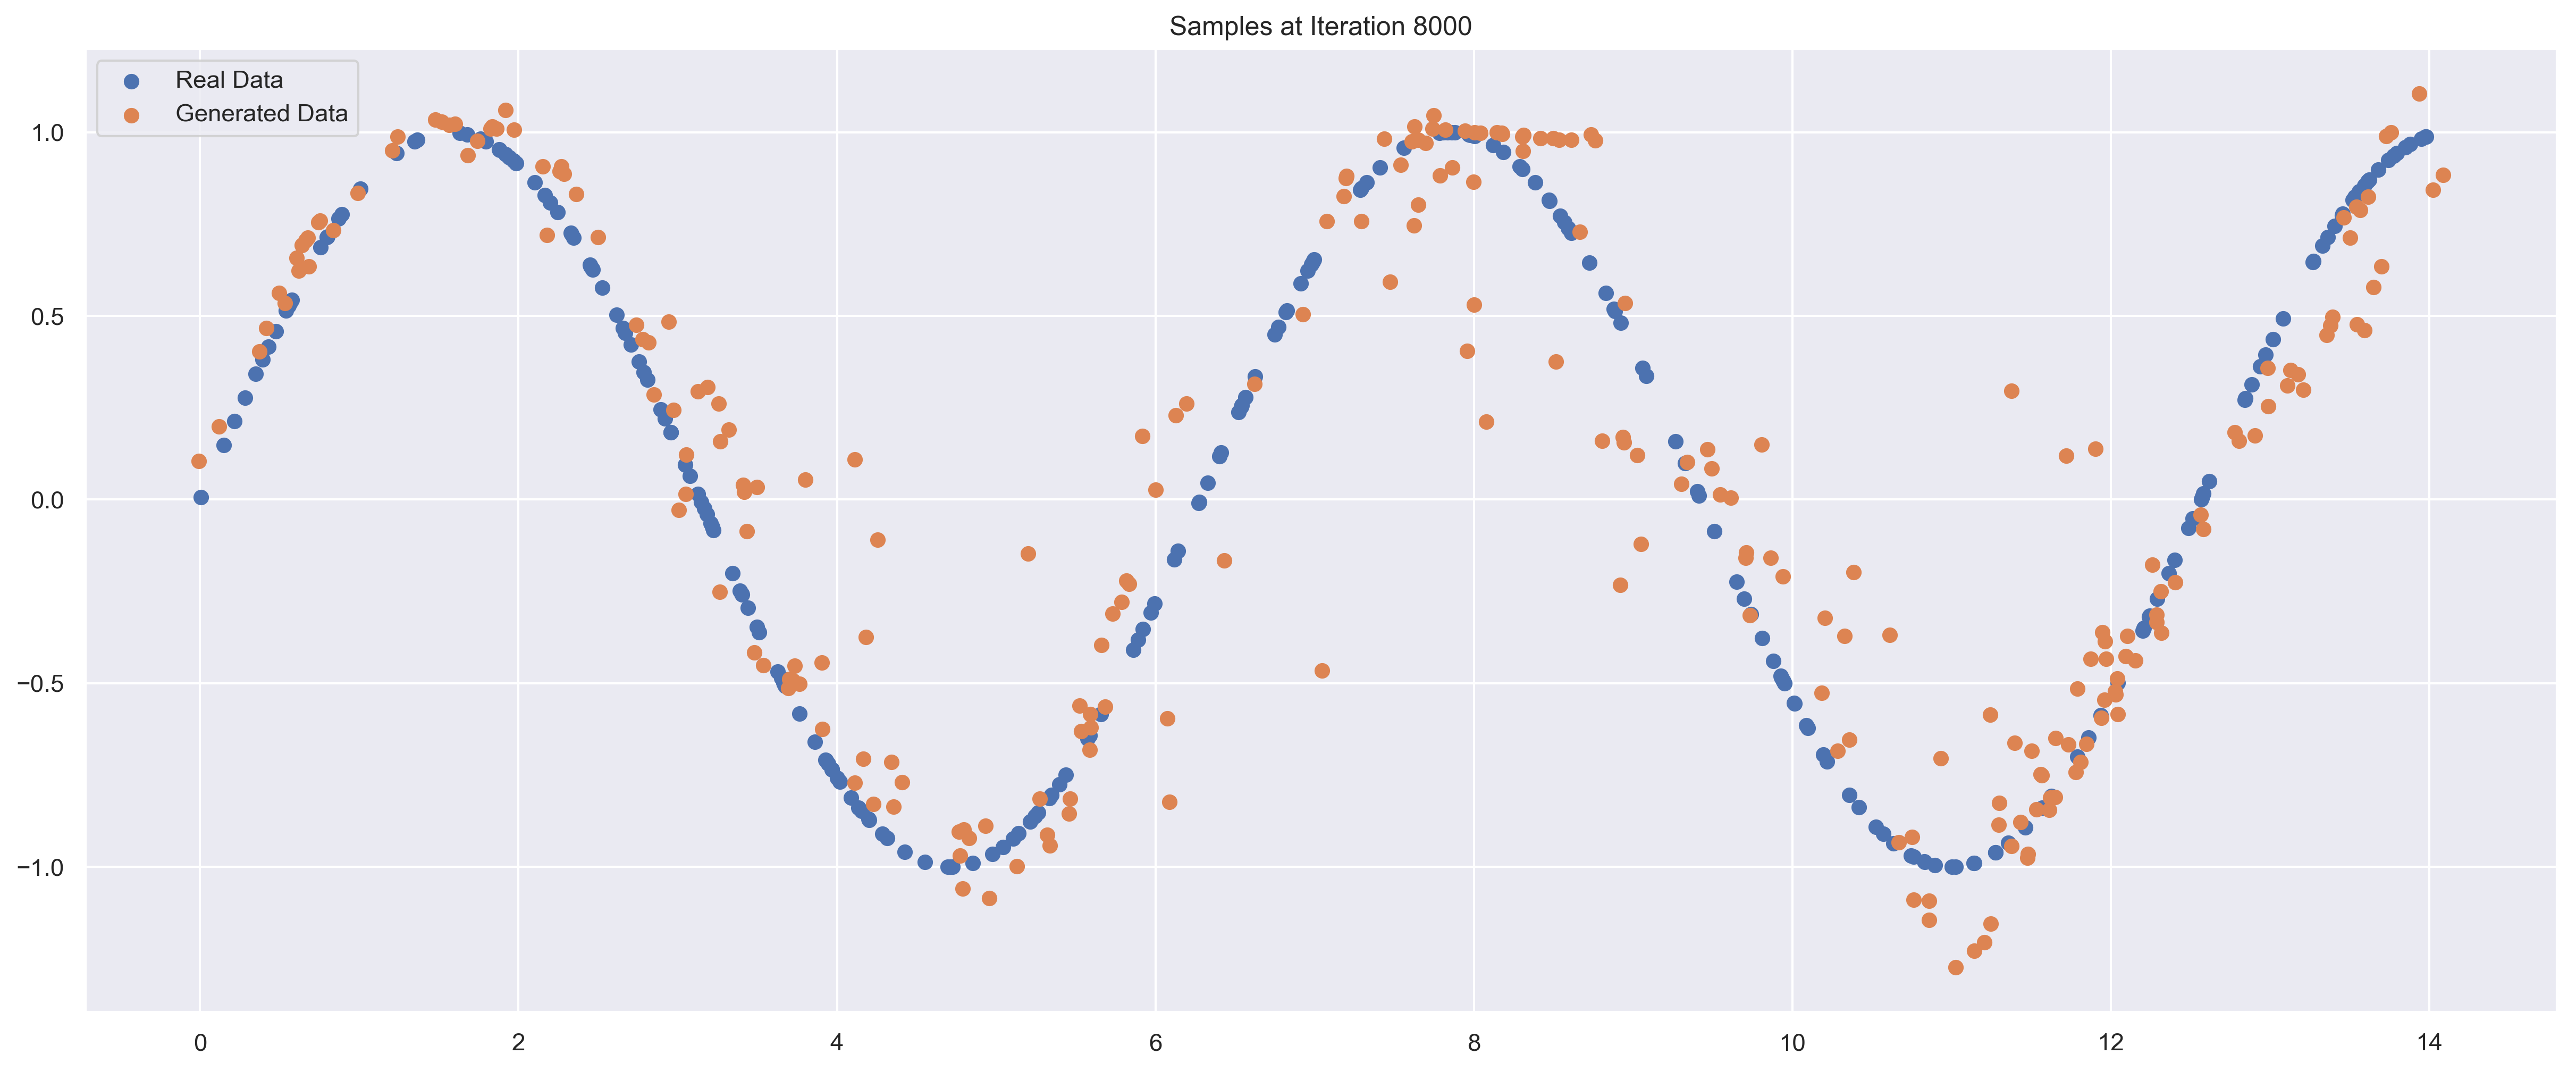

Iterations: 8500	 Discriminator loss: 1.2587	 Generator loss: 0.6217


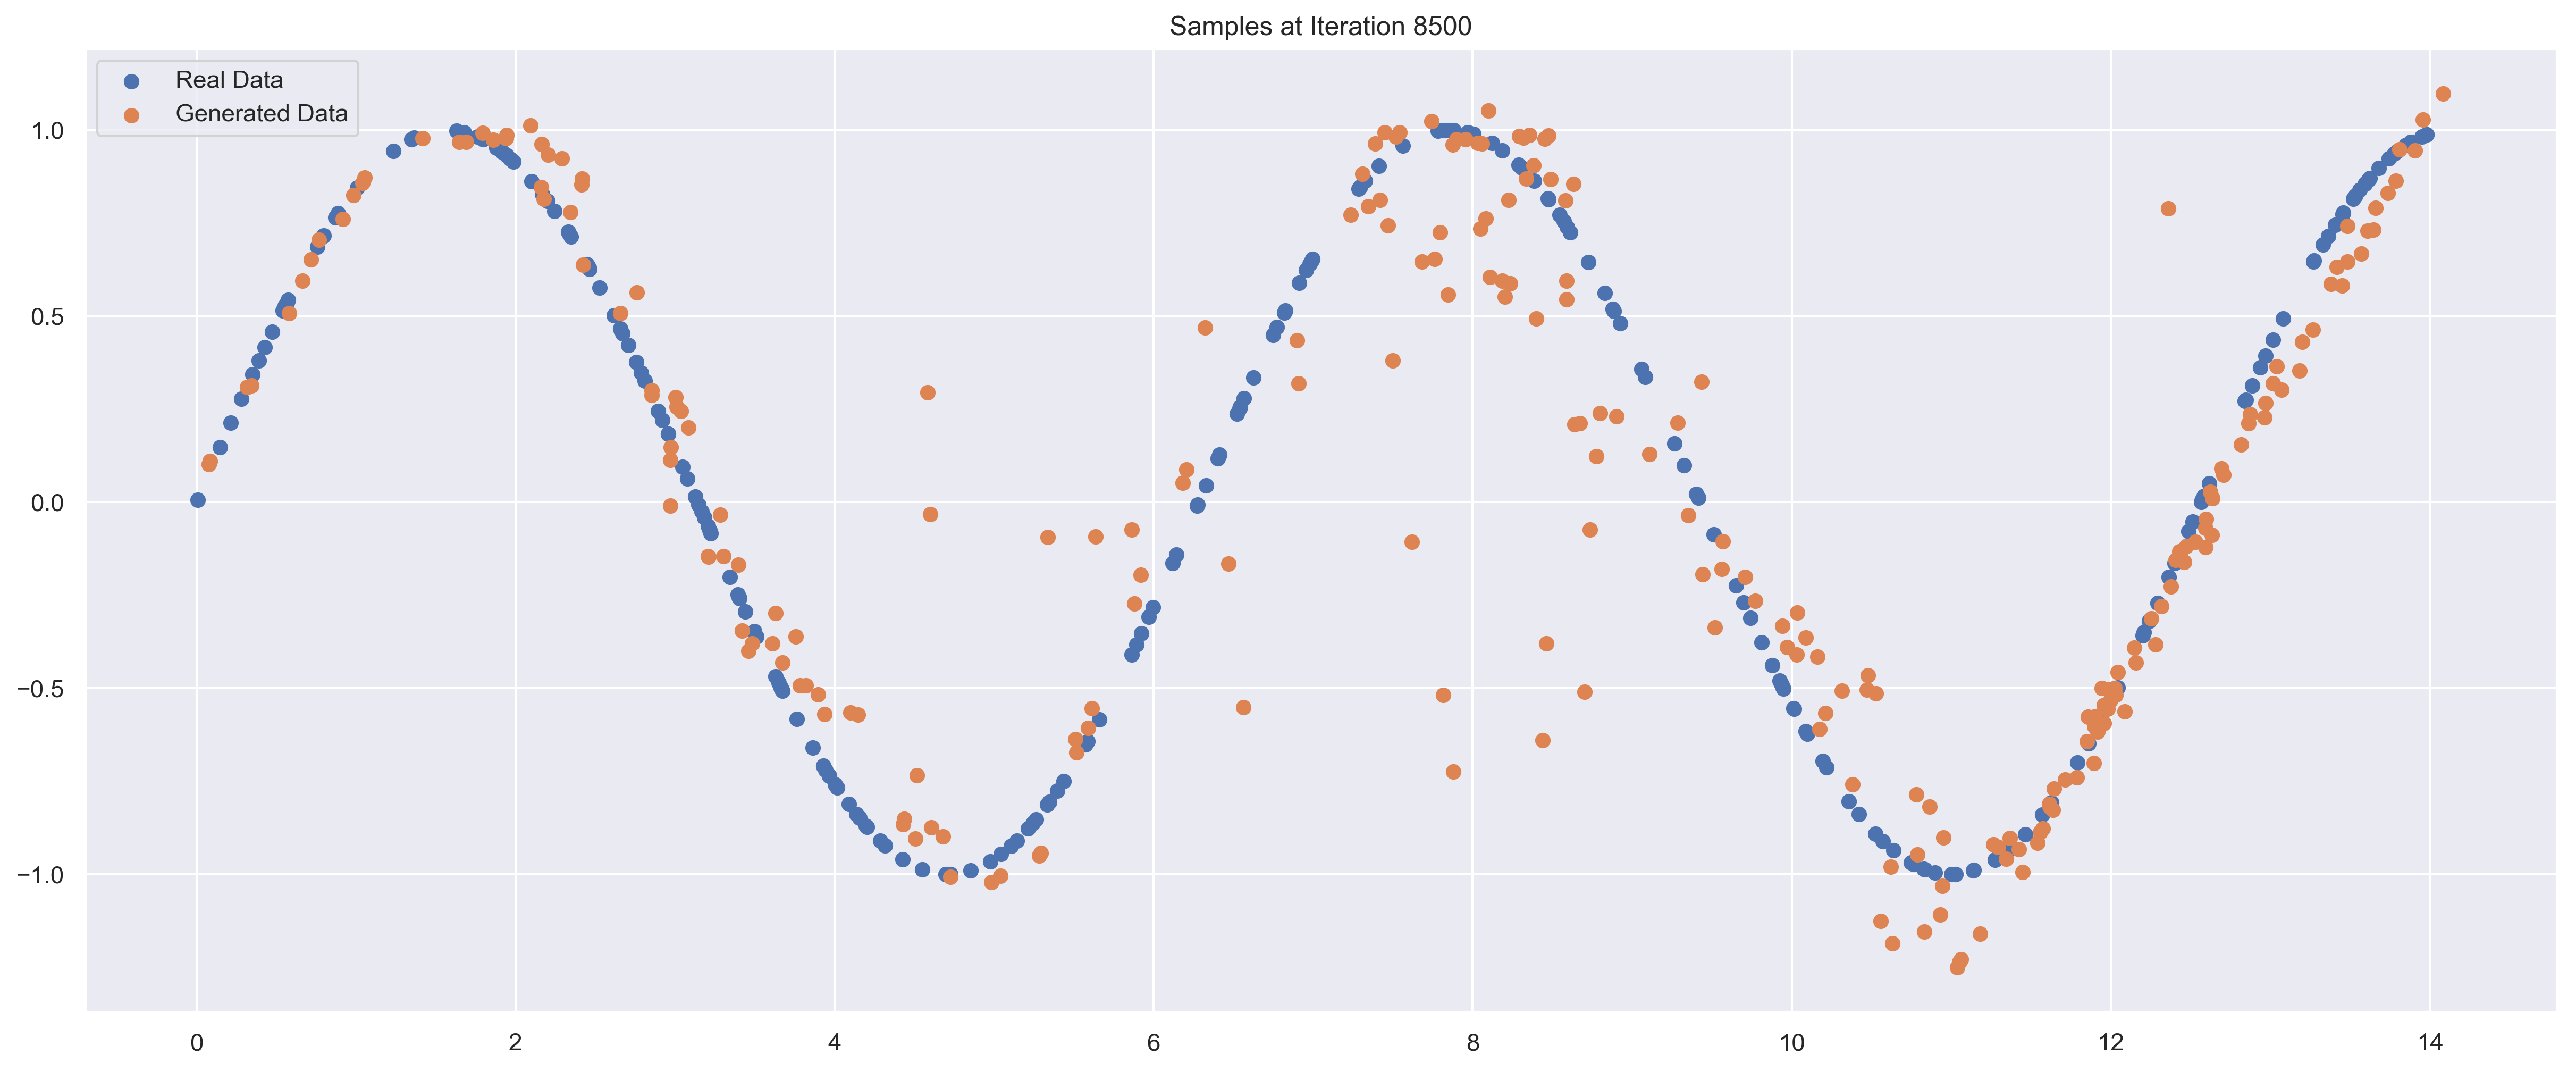

Iterations: 9000	 Discriminator loss: 1.2792	 Generator loss: 0.6217


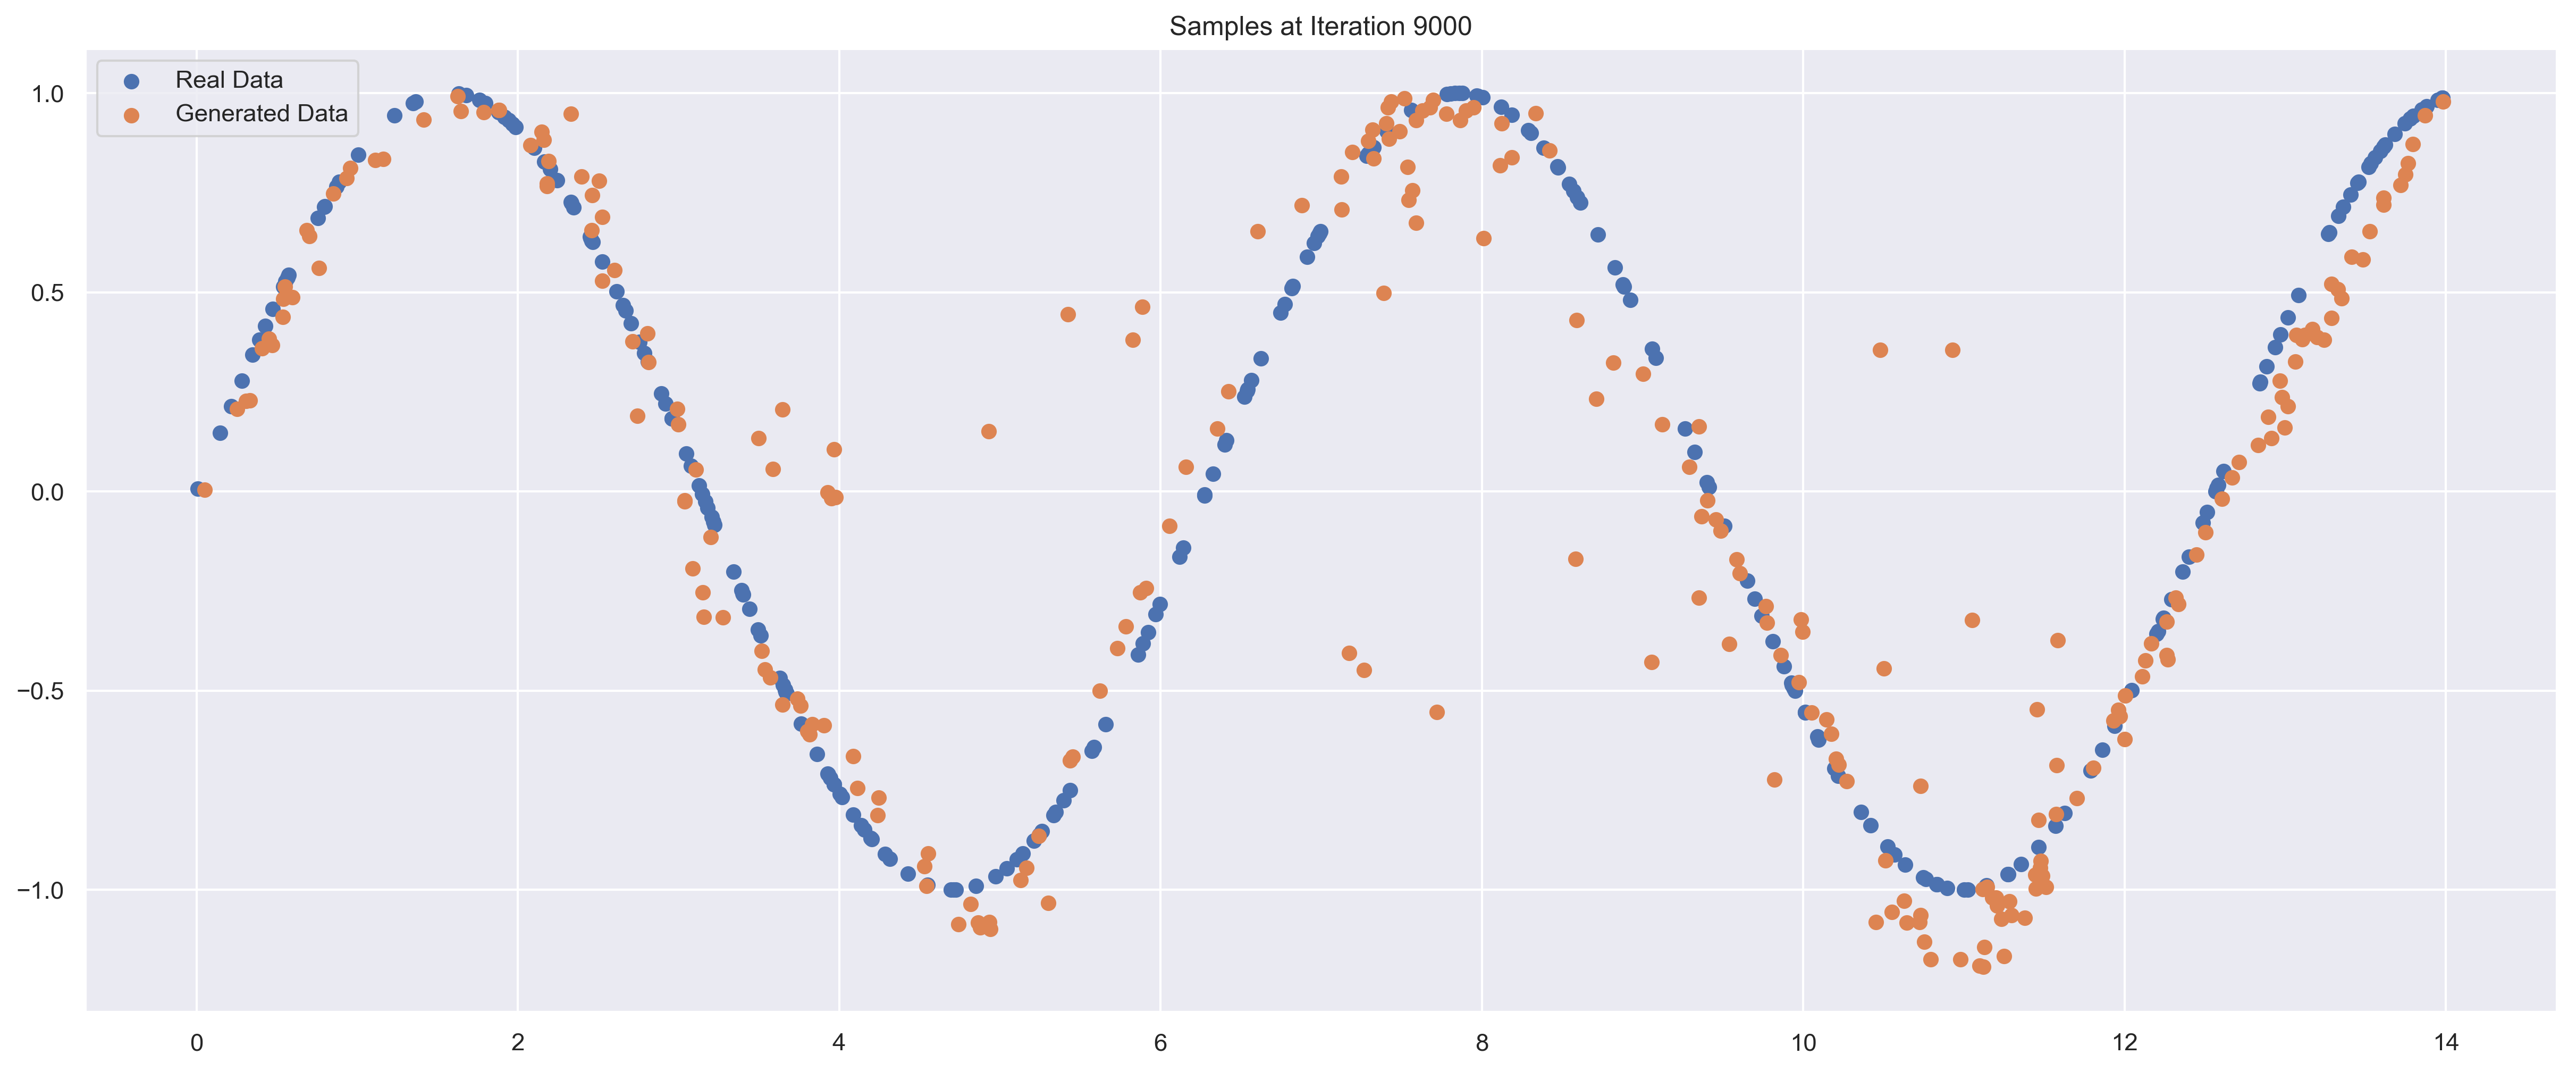

Iterations: 9500	 Discriminator loss: 1.2513	 Generator loss: 0.6295


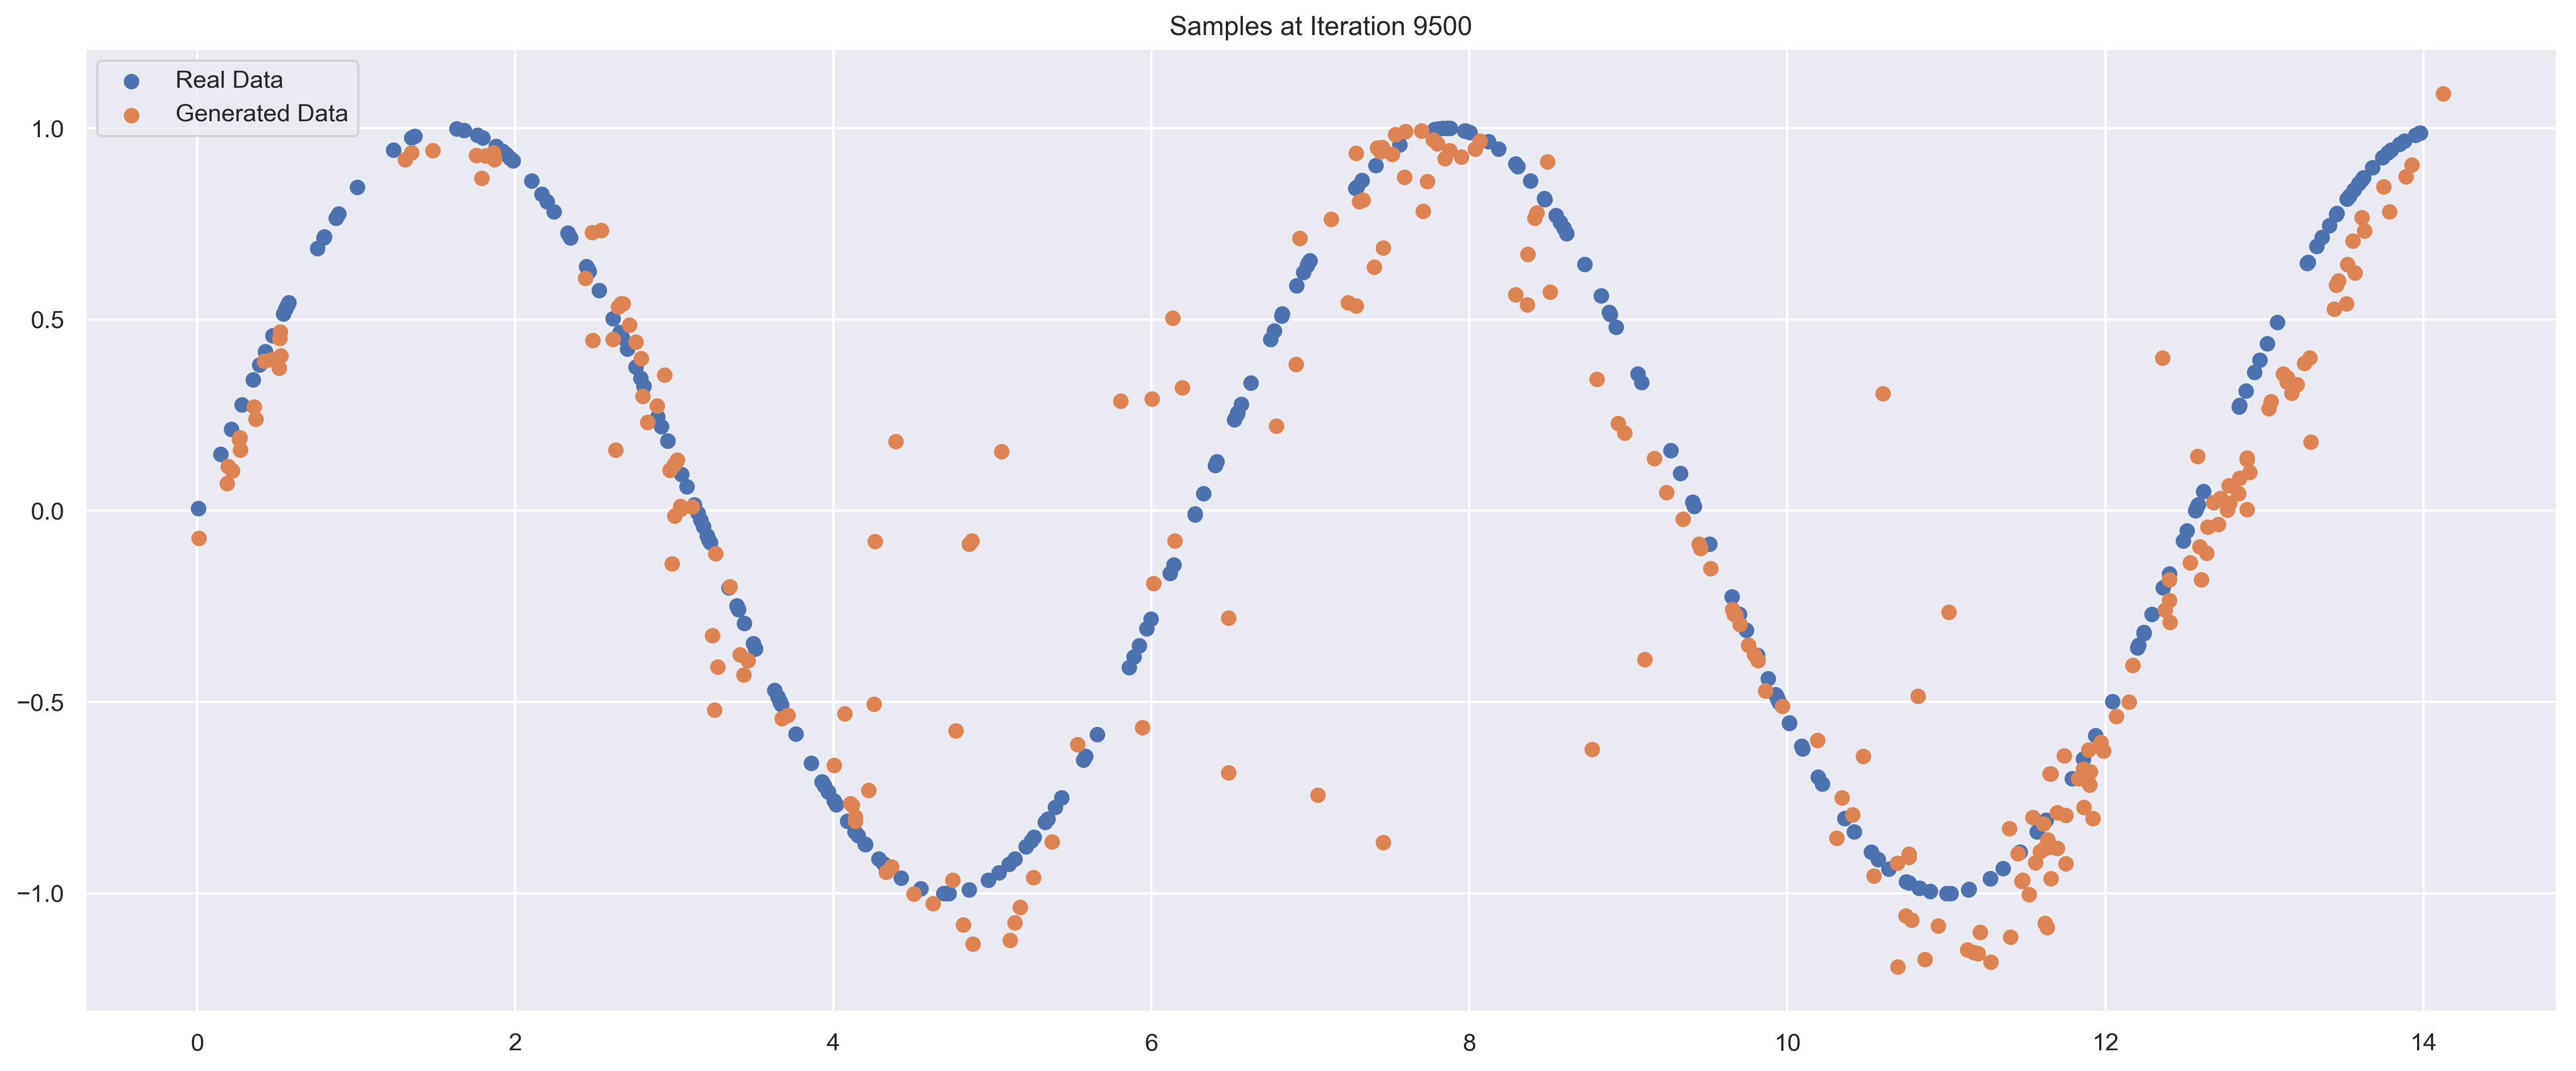

Iterations: 10000	 Discriminator loss: 1.3013	 Generator loss: 0.9927


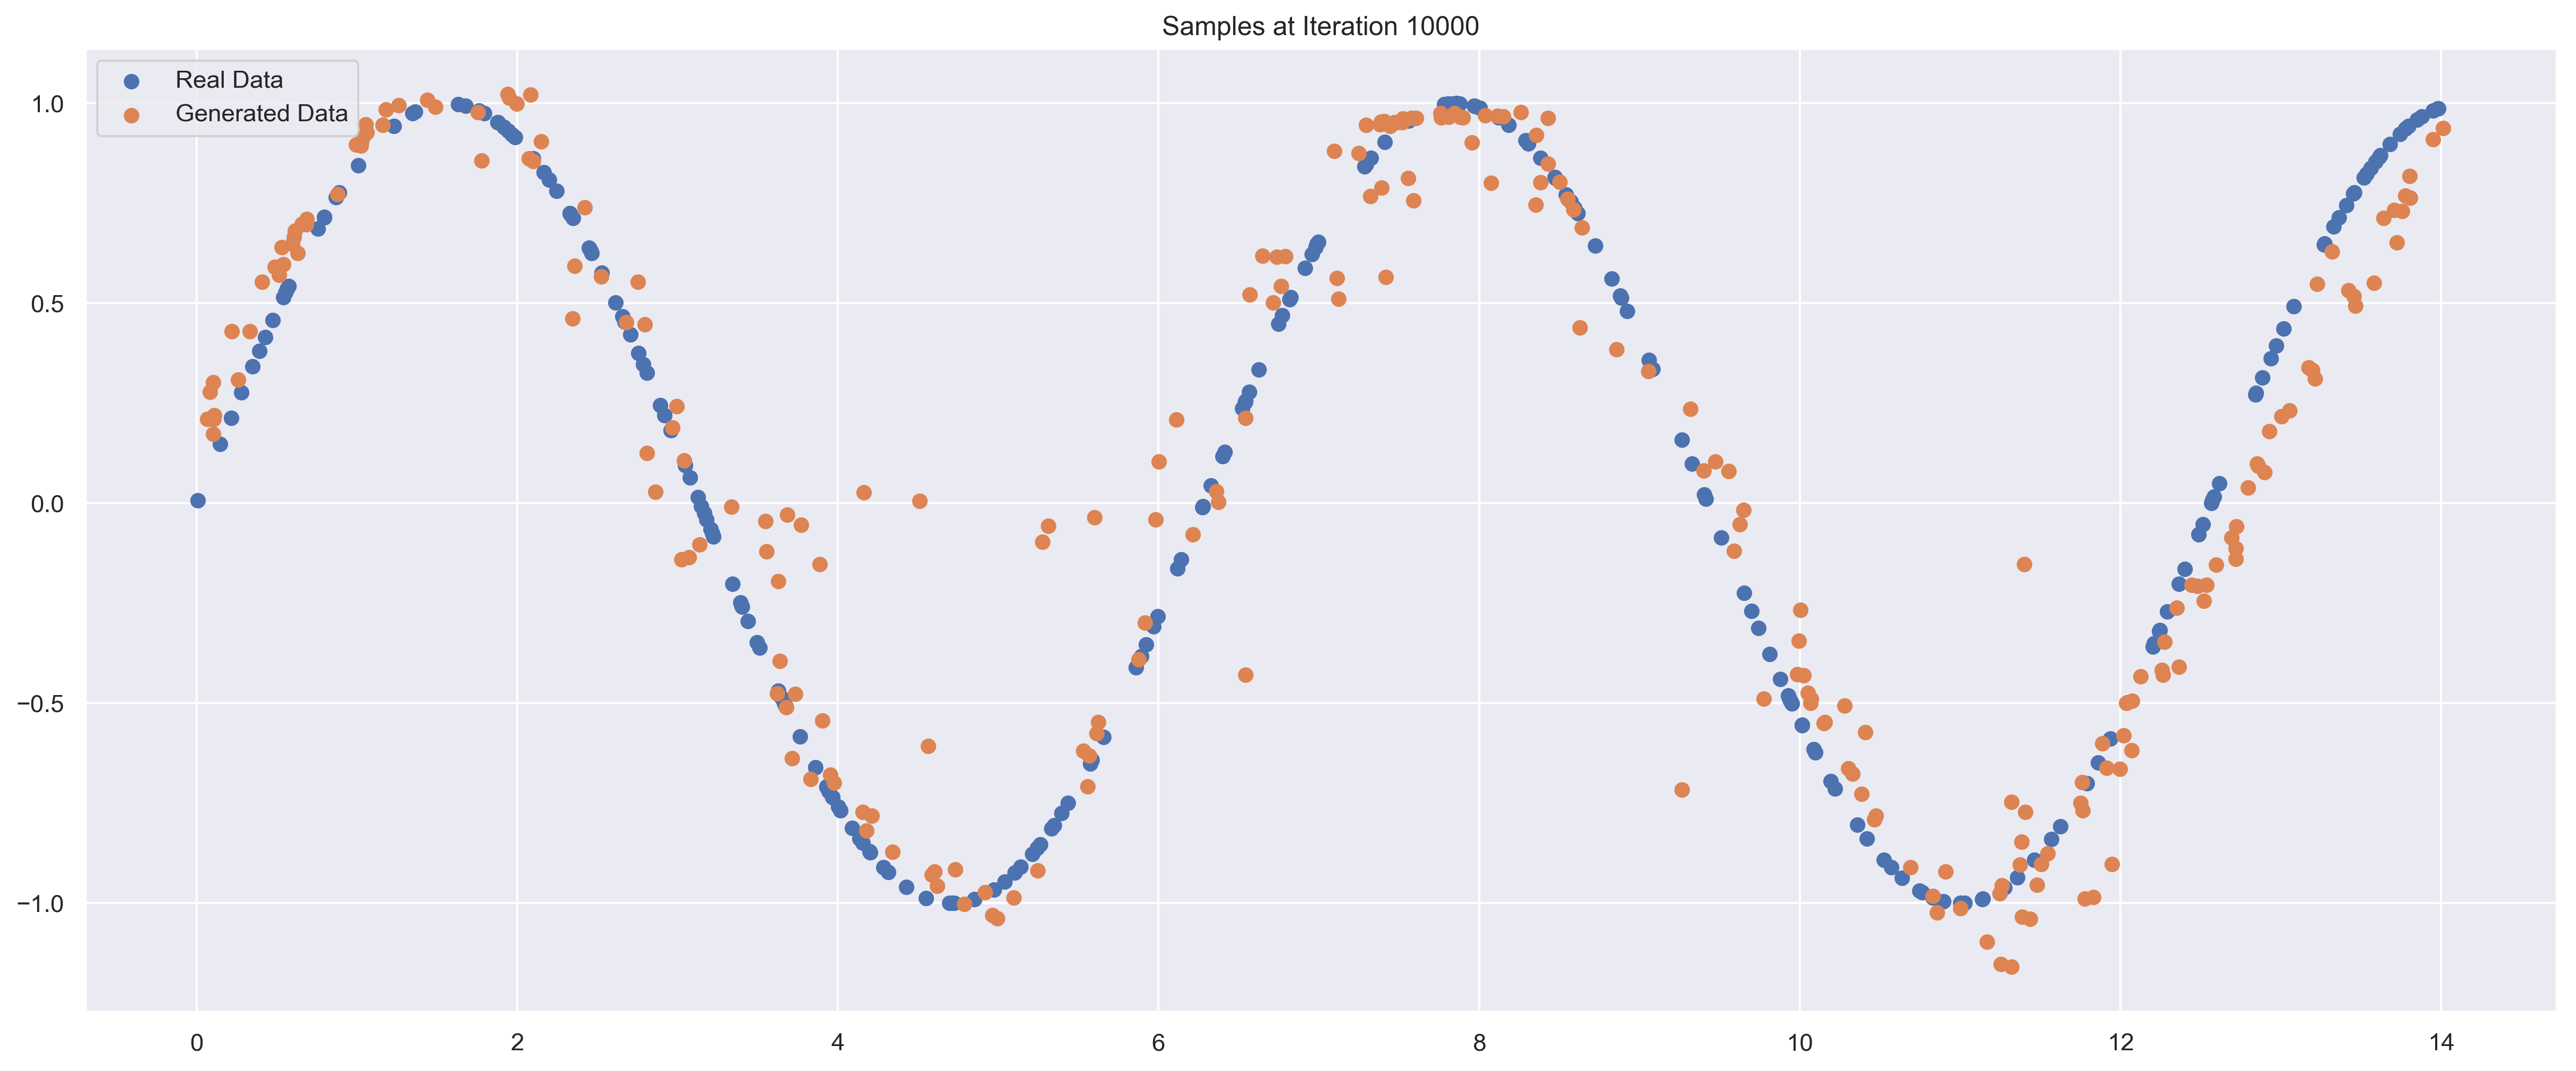

In [7]:
# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    if i%500 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        plt.figure(figsize=(20,8), dpi=300)
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
    
        plt.show()